# Fleet Assignment Optimization with Reinforcement Learning (RL)

## Intro

On January 7, 2026, Alaska Airlines announced its largest-ever aircraft order: 105 Boeing 737-10 aircraft and five Boeing 787-10 Dreamliners, with options for 35 additional 737-10s [1]. This order follows Alaska's 2024 acquisition of Hawaiian Airlines and positions Alaska Air Group as "the country's fourth-largest global airline."

The same week, Hawaiian Airlines unveiled a $600+ million investment to modernize airport infrastructure across Hawaii, including a new premium lounge at Honolulu and interior retrofits for their Airbus A330 fleet [2].

With two different aircraft types serving different missions:
- **Boeing 737-10**: High-density narrowbody for domestic and short-haul routes
- **Boeing 787-10**: Fuel-efficient widebody for transpacific and transatlantic routes

Airlines face a daily **fleet assignment problem**: which aircraft should fly which route? Assign a small 737 to a high-demand international route and you leave money on the table. Assign a large 787 to a short domestic route and operating costs eat your profit.

This notebook demonstrates how **reinforcement learning (RL)** can learn optimal fleet assignment strategies. We'll:

1. Create synthetic route and aircraft data based on Alaska's network
2. Build a custom Gym environment that simulates daily operations
3. Train a PPO agent to assign aircraft to routes
4. Compare the learned policy against a baseline heuristic

---

**References**:

[1] CNBC, "Alaska Airlines places historic Boeing order for 737-10 jets and Dreamliners," Jan. 2026.

[2] Passenger Terminal Today, "Hawaiian Airlines to invest more than US$600m in airport upgrades across Hawaii," Jan. 2026.

## Environment Setup

```bash
# Create and activate the conda environment
conda create -n fleet-optimization python=3.10 -y
conda activate fleet-optimization

# Install core libraries
conda install -c conda-forge numpy pandas matplotlib seaborn jupyter jupyterlab ipython pillow ipykernel -y
pip install stable-baselines3 gymnasium shimmy pymupdf

# Clear cache
conda clean -a -y && pip cache purge
```

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

# Display utilities
import pymupdf as fitz
from IPython.display import Image as IPythonImage
from IPython.display import display, SVG

# Reinforcement learning libraries
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback

# Set random seeds for reproducibility
np.random.seed(42)

# Set pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)

In [2]:
# Utility function to display image (png, jpg, pdf, svg) in Jupyter
def show_image(image_path, width=500, page_num=0, dpi=300):
    """Display PDF, PNG, JPG, or SVG images in notebook."""
    if image_path.lower().endswith('.pdf'):
        doc = fitz.open(image_path)
        page = doc.load_page(page_num)
        pix = page.get_pixmap(dpi=dpi)
        img_data = pix.tobytes("png")
        doc.close()
        display(IPythonImage(data=img_data, width=width))
    elif image_path.lower().endswith('.svg'):
        display(SVG(image_path))
    else:
        display(IPythonImage(filename=image_path, width=width))

# Create assets directory for plots
os.makedirs('assets', exist_ok=True)

## What is Reinforcement Learning?

**Reinforcement Learning (RL)** is a type of machine learning where an **agent** learns to make decisions by interacting with an **environment**. Think of it like training a dog: you reward good behavior and the dog learns which actions lead to treats.

### Main Components

1. **Agent**: The decision-maker (our fleet assignment AI)
2. **Environment**: The world the agent interacts with (airline routes, aircraft, demand)
3. **State**: Current situation (which routes need aircraft, current demand levels)
4. **Action**: A choice the agent makes (assign 737-10 or 787-10 to a route)
5. **Reward**: Feedback signal (profit, which is revenue gained minus costs)

### The Learning Loop

At each time step $t$:
1. Agent observes state $s_t$
2. Agent takes action $a_t$
3. Environment returns reward $r_t$ and new state $s_{t+1}$
4. Agent updates its policy to maximize future rewards

The goal is to learn a **policy** $\pi$ that maximizes cumulative rewards:

$$G_t = \sum_{k=0}^{T} \gamma^k r_{t+k}$$

where $\gamma$ (gamma) is the **discount factor** that determines how much we value future rewards versus immediate rewards.

### Analogy: Airline Fleet Planning or Operations Center

Imagine a fleet planning or operations center deciding aircraft assignments:
- **State**: Bookings, weather forecasts, crew availability
- **Action**: Assign specific aircraft to specific routes  
- **Reward**: Revenue from full flights minus costs from mismatches (e.g., using a large 787 on a short route with low demand)

Over time, the RL agent learns patterns like "use 787 for Hawaii routes in summer" or "use 737 for short business routes."

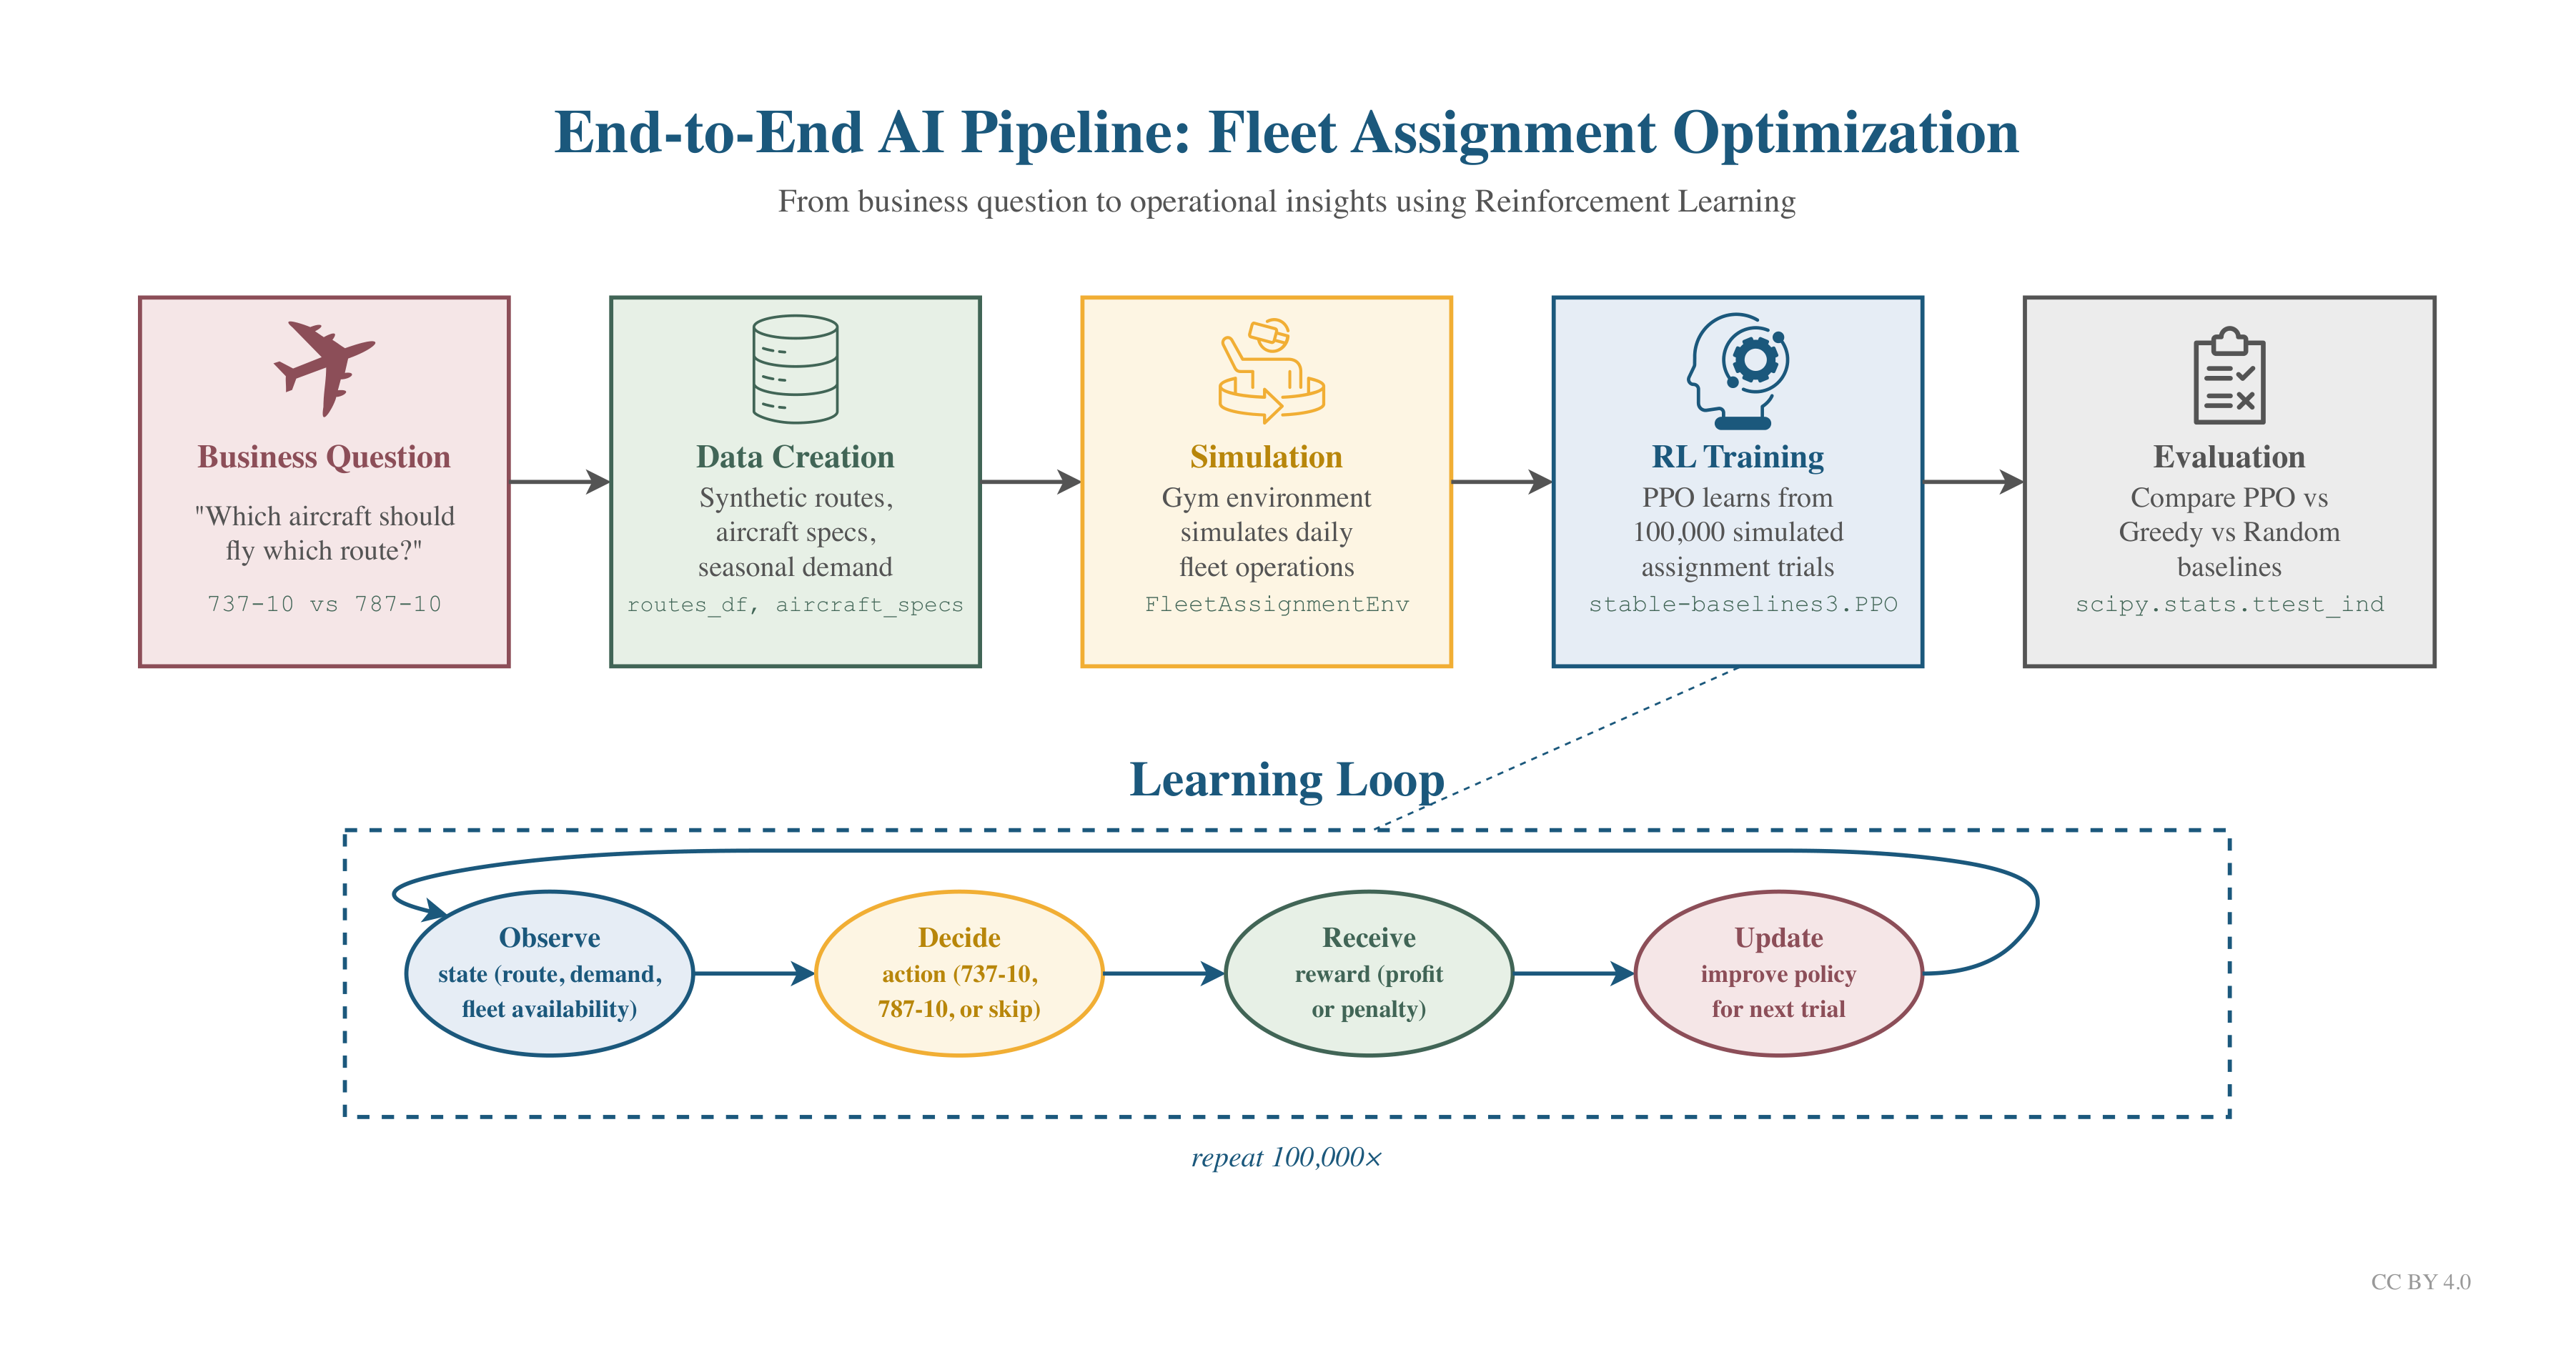

In [3]:
# Display end-to-end AI pipeline diagram
show_image('assets/pipeline-dev.pdf', width=900)

**Figure:** End-to-end AI pipeline for fleet assignment optimization. The workflow begins with a business question: "Which aircraft should fly which route?". Synthetic data representing routes, aircraft specifications, and seasonal demand feeds into a Gymnasium simulation environment (`FleetAssignmentEnv`) that models daily fleet operations. The core of the pipeline is the **learning loop**: the AI agent observes the current state (route characteristics, demand, fleet availability), decides on an assignment (737-10, 787-10, or skip), receives a reward signal (profit or penalty), and updates its policy to improve future decisions. This cycle repeats 100,000 times during training using Proximal Policy Optimization (PPO). Finally, the trained policy is evaluated against baseline strategies (random and greedy heuristics) to quantify performance improvements. The entire pipeline runs locally on a Mac with M-series processor.

## Dataset

> **DISCLAIMER**: All data in this notebook is **synthetic and hypothetical**. Aircraft specifications, route information, and performance metrics are rough estimates based on publicly available industry benchmarks. This data does not represent actual Alaska Airlines, Hawaiian Airlines, or Boeing operational data. This demonstration is for educational purposes only to illustrate reinforcement learning concepts.

### Aircraft Specifications

Alaska Airlines' new fleet order consists of two Boeing aircraft types:

| Aircraft | Role | Key Characteristics |
|----------|------|---------------------|
| **Boeing 737-10** | Domestic & short-haul | Largest 737 MAX variant, high-density seating for popular routes |
| **Boeing 787-10** | Long-haul international | Fuel-efficient widebody for transpacific/transatlantic routes |

The 737-10 offers fleet commonality with Alaska's existing 737 fleet, reducing training and maintenance costs. The 787-10 enables new long-haul routes to destinations like Rome and Seoul from Seattle.

Below, we define synthetic specifications based on publicly available industry data. Operating costs are estimated from industry benchmarks and normalized for comparison.

In [5]:
# Aircraft specifications (synthetic data based on industry benchmarks)
aircraft_specs = {
    '737-10': {
        'capacity': 230,              # Maximum passengers (monoclass)
        'range_nm': 3300,             # Range in nautical miles
        'fuel_burn_gph': 850,         # Gallons per hour
        'cruise_speed_kts': 450,      # Cruise speed in knots
        'operating_cost_per_hour': 8500,  # USD per flight hour
        'turnaround_min': 45,         # Minimum turnaround time (minutes)
        'aircraft_type': 'narrowbody'
    },
    '787-10': {
        'capacity': 330,              # Maximum passengers (typical biclass)
        'range_nm': 6430,             # Range in nautical miles
        'fuel_burn_gph': 1350,        # Gallons per hour
        'cruise_speed_kts': 490,      # Cruise speed in knots
        'operating_cost_per_hour': 15000, # USD per flight hour
        'turnaround_min': 90,         # Minimum turnaround time (minutes)
        'aircraft_type': 'widebody'
    }
}

# Convert to DataFrame for display
aircraft_df = pd.DataFrame(aircraft_specs).T
aircraft_df.index.name = 'Aircraft'
print("Aircraft Fleet Specifications")
display(aircraft_df)

Aircraft Fleet Specifications


,capacity,range_nm,fuel_burn_gph,cruise_speed_kts,operating_cost_per_hour,turnaround_min,aircraft_type
Aircraft,,,,,,,
737-10,230,3300,850,450,8500,45,narrowbody
787-10,330,6430,1350,490,15000,90,widebody


### Route Network

Alaska Airlines operates from Seattle (SEA) as its primary hub. With the addition of 787-10 Dreamliners, the airline plans to serve "at least 12 long-haul international destinations from Seattle by 2030" including new routes to Italy and South Korea.

We define a synthetic route network with 15 routes:
- **Domestic routes**: West Coast connections and transcontinental
- **Hawaii routes**: Popular leisure destinations (key to Hawaiian Airlines integration)
- **International routes**: New long-haul destinations enabled by the 787-10

Each route has:
- **Distance**: Flight distance in nautical miles
- **Base demand**: Average daily passengers (varies by season)
- **Average fare**: Revenue per passenger (economy-weighted average)
- **Route type**: Classification for ops planning

In [6]:
# Route network (synthetic data based on Alaska Airlines destinations)
routes = [
    # Domestic routes
    {'route_id': 'SEA-LAX', 'origin': 'SEA', 'destination': 'LAX', 
     'distance_nm': 954, 'base_demand': 450, 'avg_fare': 180, 'route_type': 'domestic'},
    {'route_id': 'SEA-SFO', 'origin': 'SEA', 'destination': 'SFO', 
     'distance_nm': 679, 'base_demand': 380, 'avg_fare': 150, 'route_type': 'domestic'},
    {'route_id': 'SEA-PHX', 'origin': 'SEA', 'destination': 'PHX', 
     'distance_nm': 1107, 'base_demand': 320, 'avg_fare': 190, 'route_type': 'domestic'},
    {'route_id': 'SEA-DEN', 'origin': 'SEA', 'destination': 'DEN', 
     'distance_nm': 1024, 'base_demand': 290, 'avg_fare': 175, 'route_type': 'domestic'},
    {'route_id': 'SEA-JFK', 'origin': 'SEA', 'destination': 'JFK', 
     'distance_nm': 2421, 'base_demand': 350, 'avg_fare': 320, 'route_type': 'domestic'},
    
    # Hawaii routes (key for Hawaiian Airlines integration)
    {'route_id': 'SEA-HNL', 'origin': 'SEA', 'destination': 'HNL', 
     'distance_nm': 2677, 'base_demand': 400, 'avg_fare': 380, 'route_type': 'hawaii'},
    {'route_id': 'SEA-OGG', 'origin': 'SEA', 'destination': 'OGG', 
     'distance_nm': 2640, 'base_demand': 280, 'avg_fare': 350, 'route_type': 'hawaii'},
    {'route_id': 'SEA-LIH', 'origin': 'SEA', 'destination': 'LIH', 
     'distance_nm': 2701, 'base_demand': 180, 'avg_fare': 360, 'route_type': 'hawaii'},
    {'route_id': 'SEA-KOA', 'origin': 'SEA', 'destination': 'KOA', 
     'distance_nm': 2753, 'base_demand': 200, 'avg_fare': 370, 'route_type': 'hawaii'},
    
    # International routes (new destinations enabled by 787-10)
    {'route_id': 'SEA-FCO', 'origin': 'SEA', 'destination': 'FCO', 
     'distance_nm': 5280, 'base_demand': 250, 'avg_fare': 850, 'route_type': 'international'},
    {'route_id': 'SEA-ICN', 'origin': 'SEA', 'destination': 'ICN', 
     'distance_nm': 4957, 'base_demand': 280, 'avg_fare': 780, 'route_type': 'international'},
    {'route_id': 'SEA-NRT', 'origin': 'SEA', 'destination': 'NRT', 
     'distance_nm': 4783, 'base_demand': 320, 'avg_fare': 720, 'route_type': 'international'},
    {'route_id': 'SEA-LHR', 'origin': 'SEA', 'destination': 'LHR', 
     'distance_nm': 4795, 'base_demand': 300, 'avg_fare': 900, 'route_type': 'international'},
    {'route_id': 'SEA-CDG', 'origin': 'SEA', 'destination': 'CDG', 
     'distance_nm': 4998, 'base_demand': 220, 'avg_fare': 820, 'route_type': 'international'},
    {'route_id': 'SEA-SYD', 'origin': 'SEA', 'destination': 'SYD', 
     'distance_nm': 6717, 'base_demand': 180, 'avg_fare': 1100, 'route_type': 'international'},
]

routes_df = pd.DataFrame(routes)
print("Route Network Summary")
print("-" * 50)
print(f"Total routes: {len(routes_df)}")
print(f"  Domestic: {len(routes_df[routes_df['route_type'] == 'domestic'])}")
print(f"  Hawaii: {len(routes_df[routes_df['route_type'] == 'hawaii'])}")
print(f"  International: {len(routes_df[routes_df['route_type'] == 'international'])}")
print()
display(routes_df[['route_id', 'distance_nm', 'base_demand', 'avg_fare', 'route_type']])

Route Network Summary
--------------------------------------------------
Total routes: 15
  Domestic: 5
  Hawaii: 4
  International: 6



,route_id,distance_nm,base_demand,avg_fare,route_type
0,SEA-LAX,954,450,180,domestic
1,SEA-SFO,679,380,150,domestic
2,SEA-PHX,1107,320,190,domestic
3,SEA-DEN,1024,290,175,domestic
4,SEA-JFK,2421,350,320,domestic
5,SEA-HNL,2677,400,380,hawaii
6,SEA-OGG,2640,280,350,hawaii
7,SEA-LIH,2701,180,360,hawaii
8,SEA-KOA,2753,200,370,hawaii
9,SEA-FCO,5280,250,850,international


### Seasonal Demand Patterns

Airline demand varies significantly by season:

- **Hawaii routes**: Peak in winter (December-February) when travelers escape cold weather, and summer (June-August) for family vacations during school breaks
- **International routes**: Peak in summer for European destinations; Asia routes are more stable year-round
- **Domestic routes**: Business travel is steady, with peaks around holidays

We model demand as a multiplier applied to base demand. A multiplier of 1.3 means 30% more passengers than average; 0.7 means 30% fewer.

In [7]:
# Seasonal demand multipliers by route type
# Seasons: 0=Winter (Dec-Feb), 1=Spring (Mar-May), 2=Summer (Jun-Aug), 3=Fall (Sep-Nov)
seasonal_multipliers = {
    'domestic': [0.9, 1.0, 1.1, 1.0],      # Business travel is steady
    'hawaii': [1.3, 0.9, 1.2, 0.8],        # Peak in winter (escape cold) and summer
    'international': [0.8, 1.0, 1.4, 0.9]  # Peak summer for Europe/Asia leisure
}

season_names = ['Winter', 'Spring', 'Summer', 'Fall']

seasonal_df = pd.DataFrame(seasonal_multipliers, index=season_names)
seasonal_df.index.name = 'Season'
print("Seasonal Demand Multipliers by Route Type")
display(seasonal_df)

Seasonal Demand Multipliers by Route Type


,domestic,hawaii,international
Season,,,
Winter,0.9,1.3,0.8
Spring,1.0,0.9,1.0
Summer,1.1,1.2,1.4
Fall,1.0,0.8,0.9


### Operational Constraints

Real airline operations involve complex constraints:

1. **Crew availability**: Pilots and cabin crew have duty time limits and rest requirements according to regulations and collective bargaining agreements (CBA)
2. **Maintenance windows**: Aircraft need regular maintenance checks (for Boeing, and A-check is done every 500 flight hours)
3. **Airport slots**: Some airports have limited takeoff/landing slots
4. **Fleet availability**: Not all aircraft are available every day

For this simplified model, we define:
- **Fleet size**: Number of each aircraft type available
- **Maintenance rate**: Percentage of fleet unavailable on any given day
- **Crew availability**: Simplified as a probability that crew is available for a route

In [8]:
# Fleet availability constraints
fleet_constraints = {
    '737-10': {
        'total_fleet': 40,           # Total aircraft in fleet
        'maintenance_rate': 0.10,    # 10% in maintenance on average
        'min_available': 30          # Minimum guaranteed available
    },
    '787-10': {
        'total_fleet': 5,            # Initial Dreamliner delivery
        'maintenance_rate': 0.15,    # Higher maintenance for new type
        'min_available': 3           # Minimum guaranteed available
    }
}

# Crew availability by route type (probability crew is available)
crew_availability = {
    'domestic': 0.95,       # High availability for familiar routes
    'hawaii': 0.90,         # Slightly lower (longer duty days)
    'international': 0.85   # Lowest (requires special qualifications)
}

print("Fleet Availability Constraints")
print("-" * 50)
for aircraft, constraints in fleet_constraints.items():
    available = int(constraints['total_fleet'] * (1 - constraints['maintenance_rate']))
    print(f"{aircraft}: {constraints['total_fleet']} total, "
          f"~{available} typically available")

print("\nCrew Availability by Route Type")
print("-" * 50)
for route_type, availability in crew_availability.items():
    print(f"  {route_type.capitalize()}: {availability*100:.0f}%")

Fleet Availability Constraints
--------------------------------------------------
737-10: 40 total, ~36 typically available
787-10: 5 total, ~4 typically available

Crew Availability by Route Type
--------------------------------------------------
  Domestic: 95%
  Hawaii: 90%
  International: 85%


### Data Summary

Now we consolidate all data into a single structure that the RL environment will use. We also add derived metrics like estimated flight time and expected revenue per route.

In [9]:
# Consolidate all data into a unified dataset dictionary
dataset = {
    'aircraft': aircraft_specs,
    'routes': routes_df,
    'seasonal_multipliers': seasonal_multipliers,
    'season_names': season_names,
    'fleet_constraints': fleet_constraints,
    'crew_availability': crew_availability
}

# Add derived metrics to routes
def calculate_flight_time(distance_nm, aircraft_type):
    """Estimate flight time in hours based on distance and aircraft cruise speed."""
    speed = aircraft_specs[aircraft_type]['cruise_speed_kts']
    return distance_nm / speed

def estimate_revenue(row, aircraft_type, season_idx=2):
    """Estimate revenue for a route with given aircraft and season."""
    capacity = aircraft_specs[aircraft_type]['capacity']
    multiplier = seasonal_multipliers[row['route_type']][season_idx]
    demand = row['base_demand'] * multiplier
    
    # Load factor: min of 1.0 (full cabin) or demand/capacity
    load_factor = min(1.0, demand / capacity)
    passengers = int(capacity * load_factor)
    
    return passengers * row['avg_fare']

def estimate_cost(row, aircraft_type):
    """Estimate operating cost for a route with given aircraft."""
    flight_time = calculate_flight_time(row['distance_nm'], aircraft_type)
    hourly_cost = aircraft_specs[aircraft_type]['operating_cost_per_hour']
    return flight_time * hourly_cost

# Calculate metrics for each route-aircraft combination
print("Route-Aircraft Metrics (Summer Season)")

metrics = []
for _, route in routes_df.iterrows():
    for aircraft in ['737-10', '787-10']:
        # Check if aircraft can reach destination
        can_operate = route['distance_nm'] <= aircraft_specs[aircraft]['range_nm']
        
        if can_operate:
            revenue = estimate_revenue(route, aircraft, season_idx=2)
            cost = estimate_cost(route, aircraft)
            profit = revenue - cost
            flight_hours = calculate_flight_time(route['distance_nm'], aircraft)
            
            metrics.append({
                'route': route['route_id'],
                'aircraft': aircraft,
                'flight_hours': round(flight_hours, 1),
                'revenue': revenue,
                'cost': round(cost),
                'profit': round(profit),
                'viable': profit > 0
            })

metrics_df = pd.DataFrame(metrics)
display(metrics_df.head(10))

Route-Aircraft Metrics (Summer Season)


,route,aircraft,flight_hours,revenue,cost,profit,viable
0,SEA-LAX,737-10,2.1,41400,18020,23380,True
1,SEA-LAX,787-10,1.9,59400,29204,30196,True
2,SEA-SFO,737-10,1.5,34500,12826,21674,True
3,SEA-SFO,787-10,1.4,49500,20786,28714,True
4,SEA-PHX,737-10,2.5,43700,20910,22790,True
5,SEA-PHX,787-10,2.3,62700,33888,28812,True
6,SEA-DEN,737-10,2.3,40250,19342,20908,True
7,SEA-DEN,787-10,2.1,55825,31347,24478,True
8,SEA-JFK,737-10,5.4,73600,45730,27870,True
9,SEA-JFK,787-10,4.9,105600,74112,31488,True


### Route Distance vs. Demand

The chart below shows each route's distance and demand. This visualization helps understand why different aircraft are suited for different routes:

- **Short-haul routes** (under 2,500 nm): Better served by the fuel-efficient 737-10
- **Long-haul routes** (over 3,500 nm): Require the 787-10's extended range

In [10]:
# Create route visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Color mapping for route types
colors = {'domestic': '#1B587C', 'hawaii': '#426556', 'international': '#8D4F58'}
route_type_colors = routes_df['route_type'].map(colors)

# Scatter plot
scatter = ax.scatter(
    routes_df['distance_nm'], 
    routes_df['base_demand'],
    c=route_type_colors,
    s=routes_df['avg_fare'] / 3,  # Size by fare
    alpha=0.7,
    edgecolors='white',
    linewidth=1
)

# Add route labels
for _, row in routes_df.iterrows():
    ax.annotate(
        row['route_id'].split('-')[1],  # Just destination code
        (row['distance_nm'], row['base_demand']),
        fontsize=8,
        ha='center',
        va='bottom',
        xytext=(0, 5),
        textcoords='offset points'
    )

# Add aircraft range reference lines
ax.axvline(x=aircraft_specs['737-10']['range_nm'], color='#555555', 
           linestyle='--', alpha=0.5, label='737-10 max range')
ax.axvline(x=aircraft_specs['787-10']['range_nm'], color='#F1AE35', 
           linestyle='--', alpha=0.5, label='787-10 max range')

# Labels and styling
ax.set_xlabel('Distance (nautical miles)', fontsize=11)
ax.set_ylabel('Base Daily Demand (passengers)', fontsize=11)
ax.set_title('Alaska Airlines Route Network: Distance vs. Demand', fontsize=12, fontweight='bold')

# Custom legend for route types
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#1B587C', 
           markersize=10, label='Domestic'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#426556', 
           markersize=10, label='Hawaii'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#8D4F58', 
           markersize=10, label='International'),
    Line2D([0], [0], color='#555555', linestyle='--', label='737-10 range'),
    Line2D([0], [0], color='#F1AE35', linestyle='--', label='787-10 range'),
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=9)

ax.set_xlim(0, 7500)
ax.grid(True, alpha=0.3)
sns.despine()

plt.tight_layout()
plt.savefig('assets/route_network-dev.pdf', bbox_inches='tight', dpi=300)
plt.close()

print("Saved: assets/route_network-dev.pdf")

Saved: assets/route_network-dev.pdf


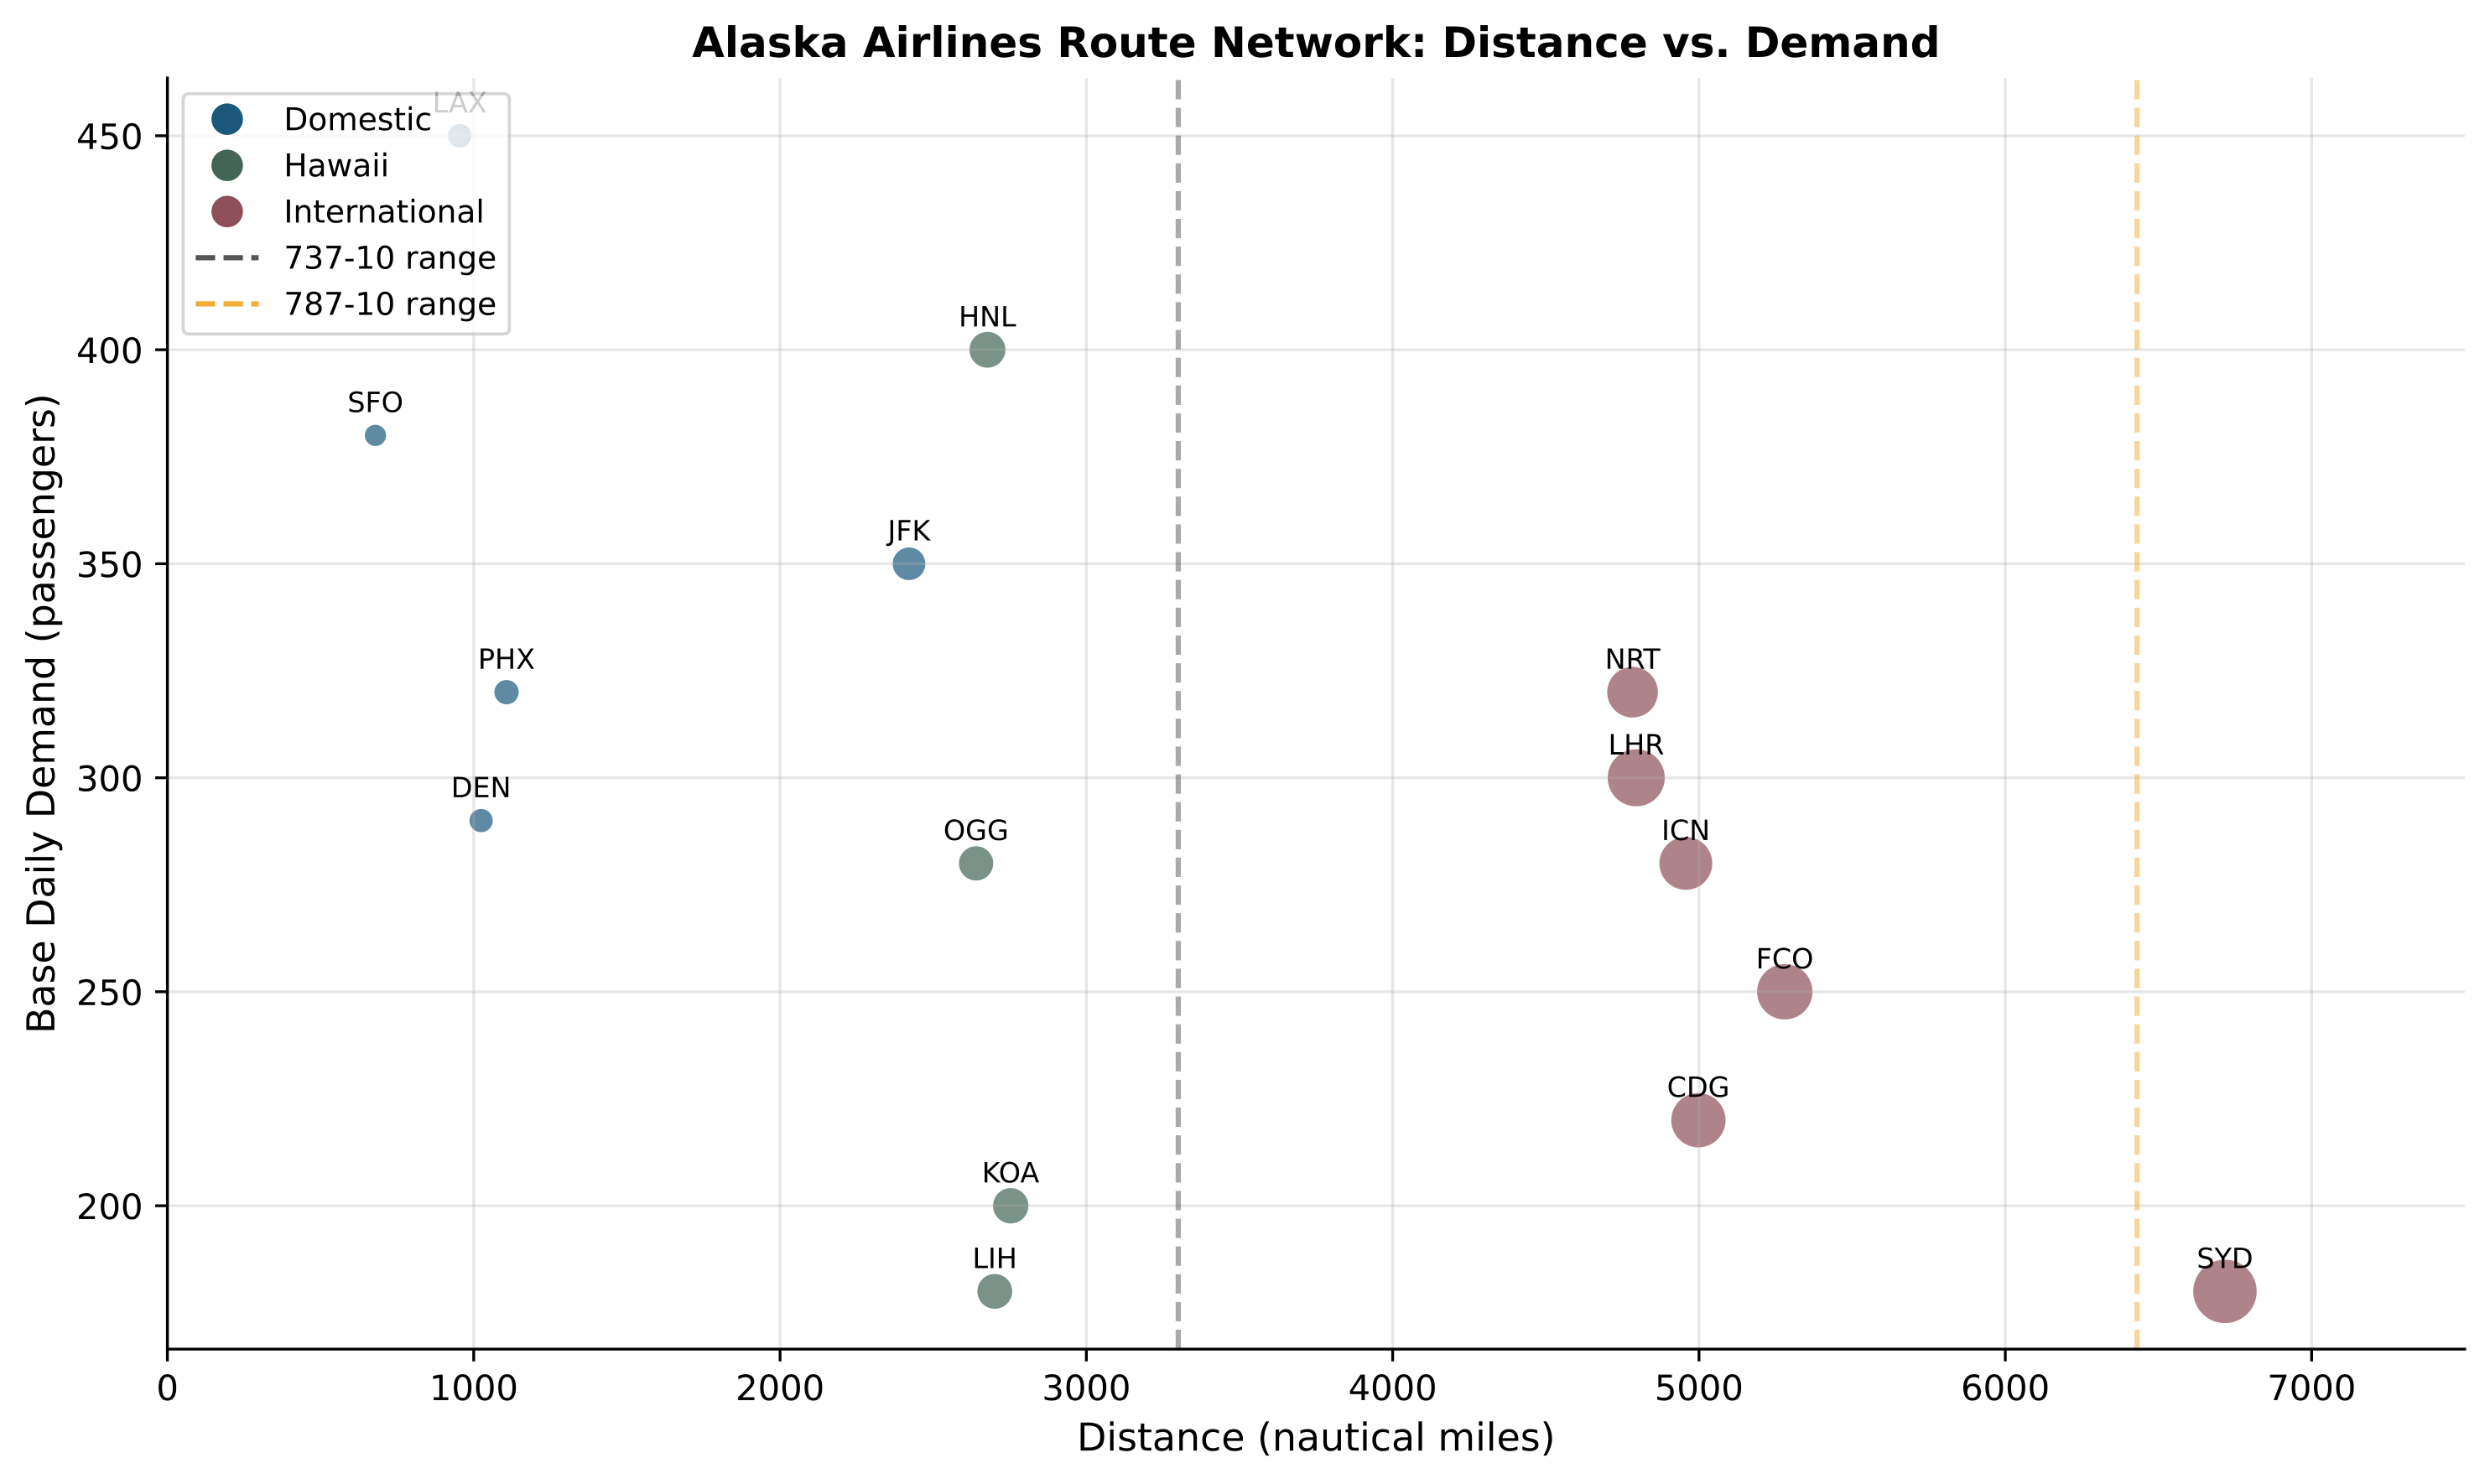

In [11]:
show_image('assets/route_network-dev.pdf', width=800)

**Figure:** Alaska Airlines route network showing distance vs. base daily demand. Bubble size represents average fare. Domestic routes (blue) are within 737-10 range. Hawaii routes (green) are near the 737-10 range limit. International routes (maroon) require the 787-10's extended range. Routes to the right of the gray dashed line (3,300 nm) cannot be served by the 737-10.

## Custom Gym Environment

To train an RL agent, we need to define the environment it will interact with. OpenAI Gym (now Gymnasium) provides a standard interface that any RL algorithm can use. Our environment simulates one day of fleet assignment decisions.

### Environment Components

An RL environment has three main components:

1. **State Space**: What the agent observes (route demands, aircraft availability)
2. **Action Space**: What the agent can do (assign aircraft to routes)
3. **Reward Function**: How we measure success (revenue minus costs)

### How the Environment Works

Each "episode" represents one day of operations:
1. The environment generates random seasonal demand for all routes
2. The agent observes the current state (demands, available aircraft)
3. For each route, the agent decides which aircraft to assign (or skip)
4. After all routes are processed, the environment calculates total profit
5. The reward signal tells the agent how well it did

The RL agent learns from thousands of simulated days to find the best assignment strategy.

### State Space Design

The **state** tells the agent what it needs to know to make good decisions. We include:

| Feature | Description | Why The Feature Matters |
|---------|-------------|----------------|
| Route index | Which route needs an aircraft | Different routes need different aircraft |
| Demand level | Current passenger demand | High demand routes need larger aircraft |
| Distance | Flight distance in nm | Long routes require 787 range |
| Average fare | Revenue per passenger | Prioritize high-value routes |
| Season | Current season (0-3) | Demand patterns vary by season |
| 737-10 available | Number of 737s left today | Can't assign what we don't have |
| 787-10 available | Number of 787s left today | Widebodies are scarce |
| Crew available | Is crew available (0/1) | No crew = can't operate |

The state is a vector of 8 numbers. We normalize values to [0, 1] range to help the neural network learn faster.

### Action Space Design

The agent chooses one action per route:

| Action | Meaning |
|--------|---------|
| 0 | Skip this route (no assignment) |
| 1 | Assign a Boeing 737-10 |
| 2 | Assign a Boeing 787-10 |

This is a **discrete** action space with 3 choices. The agent learns when each action makes sense:
- **Skip**: When demand is too low or no aircraft available (cancel the flight)
- **737-10**: For shorter routes within range, moderate demand
- **787-10**: For long-haul routes or high-demand routes where extra capacity pays off

### Reward Function Design

The **reward** tells the agent how good its decision was. We want to maximize profit while penalizing bad decisions.

**Reward calculation**:

$$R = \text{Revenue} - \text{Operating Cost} - \text{Penalties}$$

Where:
- **Revenue** = Passengers × Fare (capped at aircraft capacity)
- **Operating Cost** = Flight hours × Hourly cost
- **Penalties** for:
  - Assigning aircraft to routes beyond its range
  - Assigning when no aircraft is available
  - Empty seats (lost revenue opportunity)

We scale rewards to a reasonable range (typically -1 to +1) to help the neural network learn efficiently. Large rewards can cause unstable training.

### Environment Implementation

Now we implement the full Gym environment. The `FleetAssignmentEnv` class inherits from `gymnasium.Env` and implements the required methods:

- `__init__()`: Set up observation and action spaces
- `reset()`: Start a new episode with fresh demand and available aircraft
- `step(action)`: Process one assignment decision and return reward
- `_get_obs()`: Generate the current state observation
- `_calculate_reward()`: Compute profit from an assignment

In [12]:
class FleetAssignmentEnv(gym.Env):
    """
    Custom Gymnasium environment for fleet assignment optimization.
    
    The agent assigns aircraft (737-10 or 787-10) to routes to maximize profit.
    Each episode represents one day of operations across all routes.
    """
    
    metadata = {'render_modes': ['human']}
    
    def __init__(self, routes_df, aircraft_specs, seasonal_multipliers, 
                 fleet_constraints, crew_availability):
        super().__init__()
        
        # Store configuration
        self.routes_df = routes_df.reset_index(drop=True)
        self.aircraft_specs = aircraft_specs
        self.seasonal_multipliers = seasonal_multipliers
        self.fleet_constraints = fleet_constraints
        self.crew_availability = crew_availability
        self.n_routes = len(routes_df)
        
        # Aircraft types for indexing
        self.aircraft_types = ['737-10', '787-10']
        
        # Normalization constants for state space
        self.max_distance = 7000  # nm
        self.max_demand = 500     # passengers
        self.max_fare = 1200      # USD
        self.max_fleet = 50       # aircraft
        
        # Action space: 0=skip, 1=assign 737-10, 2=assign 787-10
        self.action_space = spaces.Discrete(3)
        
        # State space: 8 features normalized to [0, 1]
        # [route_idx, demand, distance, fare, season, 737_avail, 787_avail, crew_avail]
        self.observation_space = spaces.Box(
            low=0.0, high=1.0, shape=(8,), dtype=np.float32
        )
        
        # Episode tracking
        self.current_route_idx = 0
        self.current_season = 0
        self.episode_profit = 0.0
        self.available_aircraft = {}
        self.assignments = []
        
    def reset(self, seed=None, options=None):
        """Reset environment for a new episode (one day of operations)."""
        super().reset(seed=seed)
        
        # Randomly select a season
        self.current_season = self.np_random.integers(0, 4)
        
        # Initialize available aircraft (accounting for maintenance)
        self.available_aircraft = {}
        for ac_type, constraints in self.fleet_constraints.items():
            base_available = int(constraints['total_fleet'] * 
                               (1 - constraints['maintenance_rate']))
            # Add small random variation
            variation = self.np_random.integers(-2, 3)
            self.available_aircraft[ac_type] = max(
                constraints['min_available'],
                min(constraints['total_fleet'], base_available + variation)
            )
        
        # Reset episode tracking
        self.current_route_idx = 0
        self.episode_profit = 0.0
        self.assignments = []
        
        # Generate demand for this episode
        self._generate_demand()
        
        return self._get_obs(), {}
    
    def _generate_demand(self):
        """Generate demand for all routes based on season."""
        self.route_demands = []
        for _, route in self.routes_df.iterrows():
            base_demand = route['base_demand']
            multiplier = self.seasonal_multipliers[route['route_type']][self.current_season]
            # Add random noise (+/- 15%)
            noise = self.np_random.uniform(0.85, 1.15)
            demand = int(base_demand * multiplier * noise)
            self.route_demands.append(demand)
    
    def _get_obs(self):
        """Generate normalized observation for current route."""
        if self.current_route_idx >= self.n_routes:
            # Episode complete, return zeros
            return np.zeros(8, dtype=np.float32)
        
        route = self.routes_df.iloc[self.current_route_idx]
        demand = self.route_demands[self.current_route_idx]
        
        # Check crew availability (stochastic)
        crew_prob = self.crew_availability[route['route_type']]
        crew_avail = 1.0 if self.np_random.random() < crew_prob else 0.0
        
        obs = np.array([
            self.current_route_idx / self.n_routes,                          # Route index
            min(demand / self.max_demand, 1.0),                              # Demand
            route['distance_nm'] / self.max_distance,                        # Distance
            route['avg_fare'] / self.max_fare,                               # Fare
            self.current_season / 3.0,                                       # Season
            self.available_aircraft['737-10'] / self.max_fleet,              # 737 available
            self.available_aircraft['787-10'] / self.max_fleet,              # 787 available
            crew_avail                                                       # Crew available
        ], dtype=np.float32)
        
        return obs

In [13]:
# Continue FleetAssignmentEnv class - add step() and reward methods
def _step_method(self, action):
    """
    Execute one step: assign aircraft to current route.
    
    Args:
        action: 0=skip, 1=assign 737-10, 2=assign 787-10
        
    Returns:
        observation, reward, terminated, truncated, info
    """
    route = self.routes_df.iloc[self.current_route_idx]
    demand = self.route_demands[self.current_route_idx]
    
    reward = 0.0
    info = {'route': route['route_id'], 'action': action, 'valid': True}
    
    if action == 0:
        # Skip this route - small penalty for missed opportunity
        reward = -0.1
        info['assignment'] = 'skipped'
        
    else:
        # Assign aircraft
        ac_type = self.aircraft_types[action - 1]
        specs = self.aircraft_specs[ac_type]
        
        # Check if assignment is valid
        valid = True
        penalty = 0.0
        
        # Check aircraft availability
        if self.available_aircraft[ac_type] <= 0:
            valid = False
            penalty += 0.5
            info['error'] = 'no_aircraft_available'
        
        # Check range capability
        if route['distance_nm'] > specs['range_nm']:
            valid = False
            penalty += 0.5
            info['error'] = 'out_of_range'
        
        if valid:
            # Calculate revenue and cost
            reward = self._calculate_reward(route, demand, ac_type)
            self.available_aircraft[ac_type] -= 1
            self.episode_profit += reward
            info['assignment'] = ac_type
        else:
            reward = -penalty
            info['valid'] = False
    
    self.assignments.append(info)
    
    # Move to next route
    self.current_route_idx += 1
    terminated = self.current_route_idx >= self.n_routes
    
    # Get next observation
    obs = self._get_obs()
    
    return obs, reward, terminated, False, info

def _calc_reward_method(self, route, demand, aircraft_type):
    """Calculate profit for assigning aircraft to route."""
    specs = self.aircraft_specs[aircraft_type]
    
    # Revenue: passengers * fare
    capacity = specs['capacity']
    passengers = min(demand, capacity)
    revenue = passengers * route['avg_fare']
    
    # Operating cost
    flight_time = route['distance_nm'] / specs['cruise_speed_kts']
    operating_cost = flight_time * specs['operating_cost_per_hour']
    
    # Empty seat penalty (opportunity cost)
    empty_seats = max(0, capacity - demand)
    empty_penalty = empty_seats * 20  # $20 per empty seat
    
    # Oversizing penalty (using large plane on small route)
    if aircraft_type == '787-10' and route['distance_nm'] < 2000:
        oversizing_penalty = 5000  # Inefficient use of widebody
    else:
        oversizing_penalty = 0
    
    # Net profit
    profit = revenue - operating_cost - empty_penalty - oversizing_penalty
    
    # Scale reward to reasonable range
    scaled_reward = profit / 50000  # Normalize
    
    return scaled_reward

# Attach methods to the class
FleetAssignmentEnv.step = _step_method
FleetAssignmentEnv._calculate_reward = _calc_reward_method

### Testing the Environment

Before training, we verify the environment works correctly with random actions. This helps catch bugs early and ensures the state/action/reward loop functions as expected.

In [14]:
# Create environment instance
env = FleetAssignmentEnv(
    routes_df=routes_df,
    aircraft_specs=aircraft_specs,
    seasonal_multipliers=seasonal_multipliers,
    fleet_constraints=fleet_constraints,
    crew_availability=crew_availability
)

print("Environment Created")
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}")
print(f"Number of routes: {env.n_routes}")

Environment Created
Observation space: Box(0.0, 1.0, (8,), float32)
Action space: Discrete(3)
Number of routes: 15


In [15]:
# Test episode with random actions
obs, info = env.reset(seed=42)

print("Running test episode with random actions")
print(f"Season: {['Winter', 'Spring', 'Summer', 'Fall'][env.current_season]}")
print(f"Initial aircraft: 737-10={env.available_aircraft['737-10']}, 787-10={env.available_aircraft['787-10']}")
print()

episode_reward = 0
step_count = 0

while True:
    action = env.action_space.sample()  # Random action
    obs, reward, terminated, truncated, info = env.step(action)
    episode_reward += reward
    step_count += 1
    
    if step_count <= 5:  # Show first 5 steps
        action_names = ['skip', '737-10', '787-10']
        print(f"Route {info['route']}: Action={action_names[action]}, "
              f"Reward={reward:.3f}, Valid={info['valid']}")
    
    if terminated:
        break

print(f"...")
print(f"\nEpisode complete after {step_count} steps")
print(f"Total episode reward: {episode_reward:.3f}")
print(f"Final aircraft: 737-10={env.available_aircraft['737-10']}, 787-10={env.available_aircraft['787-10']}")

Running test episode with random actions
Season: Winter
Initial aircraft: 737-10=37, 787-10=5

Route SEA-LAX: Action=787-10, Reward=0.504, Valid=True
Route SEA-SFO: Action=737-10, Reward=0.433, Valid=True
Route SEA-PHX: Action=737-10, Reward=0.456, Valid=True
Route SEA-DEN: Action=787-10, Reward=0.303, Valid=True
Route SEA-JFK: Action=787-10, Reward=0.630, Valid=True
...

Episode complete after 15 steps
Total episode reward: 2.050
Final aircraft: 737-10=33, 787-10=0


In [16]:
# Verify stable-baselines3 compatibility using check_env
from stable_baselines3.common.env_checker import check_env

# Create fresh environment for checking
test_env = FleetAssignmentEnv(
    routes_df=routes_df,
    aircraft_specs=aircraft_specs,
    seasonal_multipliers=seasonal_multipliers,
    fleet_constraints=fleet_constraints,
    crew_availability=crew_availability
)

try:
    check_env(test_env, warn=True)
    print("Environment passed stable-baselines3 compatibility check")
except Exception as e:
    print(f"Environment check failed: {e}")

# Cleanup
del test_env

Environment passed stable-baselines3 compatibility check


In [17]:
# Show example observation breakdown
obs, _ = env.reset(seed=123)

feature_names = [
    'Route Index (normalized)',
    'Demand (normalized)',
    'Distance (normalized)',
    'Average Fare (normalized)',
    'Season (normalized)',
    '737-10 Available (normalized)',
    '787-10 Available (normalized)',
    'Crew Available (0 or 1)'
]

print("Example Observation Vector")
for name, value in zip(feature_names, obs):
    print(f"  {name}: {value:.3f}")

# Show what the raw values represent
route = routes_df.iloc[0]
print(f"\nFor route: {route['route_id']}")
print(f"  Raw demand: ~{int(obs[1] * env.max_demand)} passengers")
print(f"  Raw distance: {int(obs[2] * env.max_distance)} nm")
print(f"  Raw fare: ${int(obs[3] * env.max_fare)}")

Example Observation Vector
  Route Index (normalized): 0.000
  Demand (normalized): 0.742
  Distance (normalized): 0.136
  Average Fare (normalized): 0.150
  Season (normalized): 0.000
  737-10 Available (normalized): 0.740
  787-10 Available (normalized): 0.080
  Crew Available (0 or 1): 1.000

For route: SEA-LAX
  Raw demand: ~371 passengers
  Raw distance: 953 nm
  Raw fare: $180


### Episode Summary Visualization

Let's visualize one complete episode to see how random actions perform. This will serve as a baseline for comparison with our trained RL agent.

In [18]:
# Run multiple episodes with random policy to establish baseline
np.random.seed(42)
n_test_episodes = 100
random_rewards = []

for episode in range(n_test_episodes):
    obs, _ = env.reset()
    episode_reward = 0
    done = False
    
    while not done:
        action = env.action_space.sample()
        obs, reward, done, _, _ = env.step(action)
        episode_reward += reward
    
    random_rewards.append(episode_reward)

random_mean = np.mean(random_rewards)
random_std = np.std(random_rewards)

print(f"Random Policy Performance ({n_test_episodes} episodes)")
print(f"Mean episode reward: {random_mean:.3f}")
print(f"Std deviation: {random_std:.3f}")
print(f"Min reward: {np.min(random_rewards):.3f}")
print(f"Max reward: {np.max(random_rewards):.3f}")

Random Policy Performance (100 episodes)
Mean episode reward: 1.232
Std deviation: 2.279
Min reward: -2.137
Max reward: 9.547


In [19]:
# Visualize random policy reward distribution
fig, ax = plt.subplots(figsize=(8, 4))

ax.hist(random_rewards, bins=20, color='#555555', alpha=0.7, edgecolor='white')
ax.axvline(x=random_mean, color='#8D4F58', linestyle='--', linewidth=2, 
           label=f'Mean: {random_mean:.2f}')
ax.axvline(x=random_mean + random_std, color='#1B587C', linestyle=':', linewidth=1.5,
           label=f'+/- Std: {random_std:.2f}')
ax.axvline(x=random_mean - random_std, color='#1B587C', linestyle=':', linewidth=1.5)

ax.set_xlabel('Episode Reward', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('Random Policy: Episode Reward Distribution', fontsize=12, fontweight='bold')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
sns.despine()

plt.tight_layout()
plt.savefig('assets/random_policy_rewards-dev.pdf', bbox_inches='tight', dpi=300)
plt.close()

print("Saved: assets/random_policy_rewards-dev.pdf")

Saved: assets/random_policy_rewards-dev.pdf


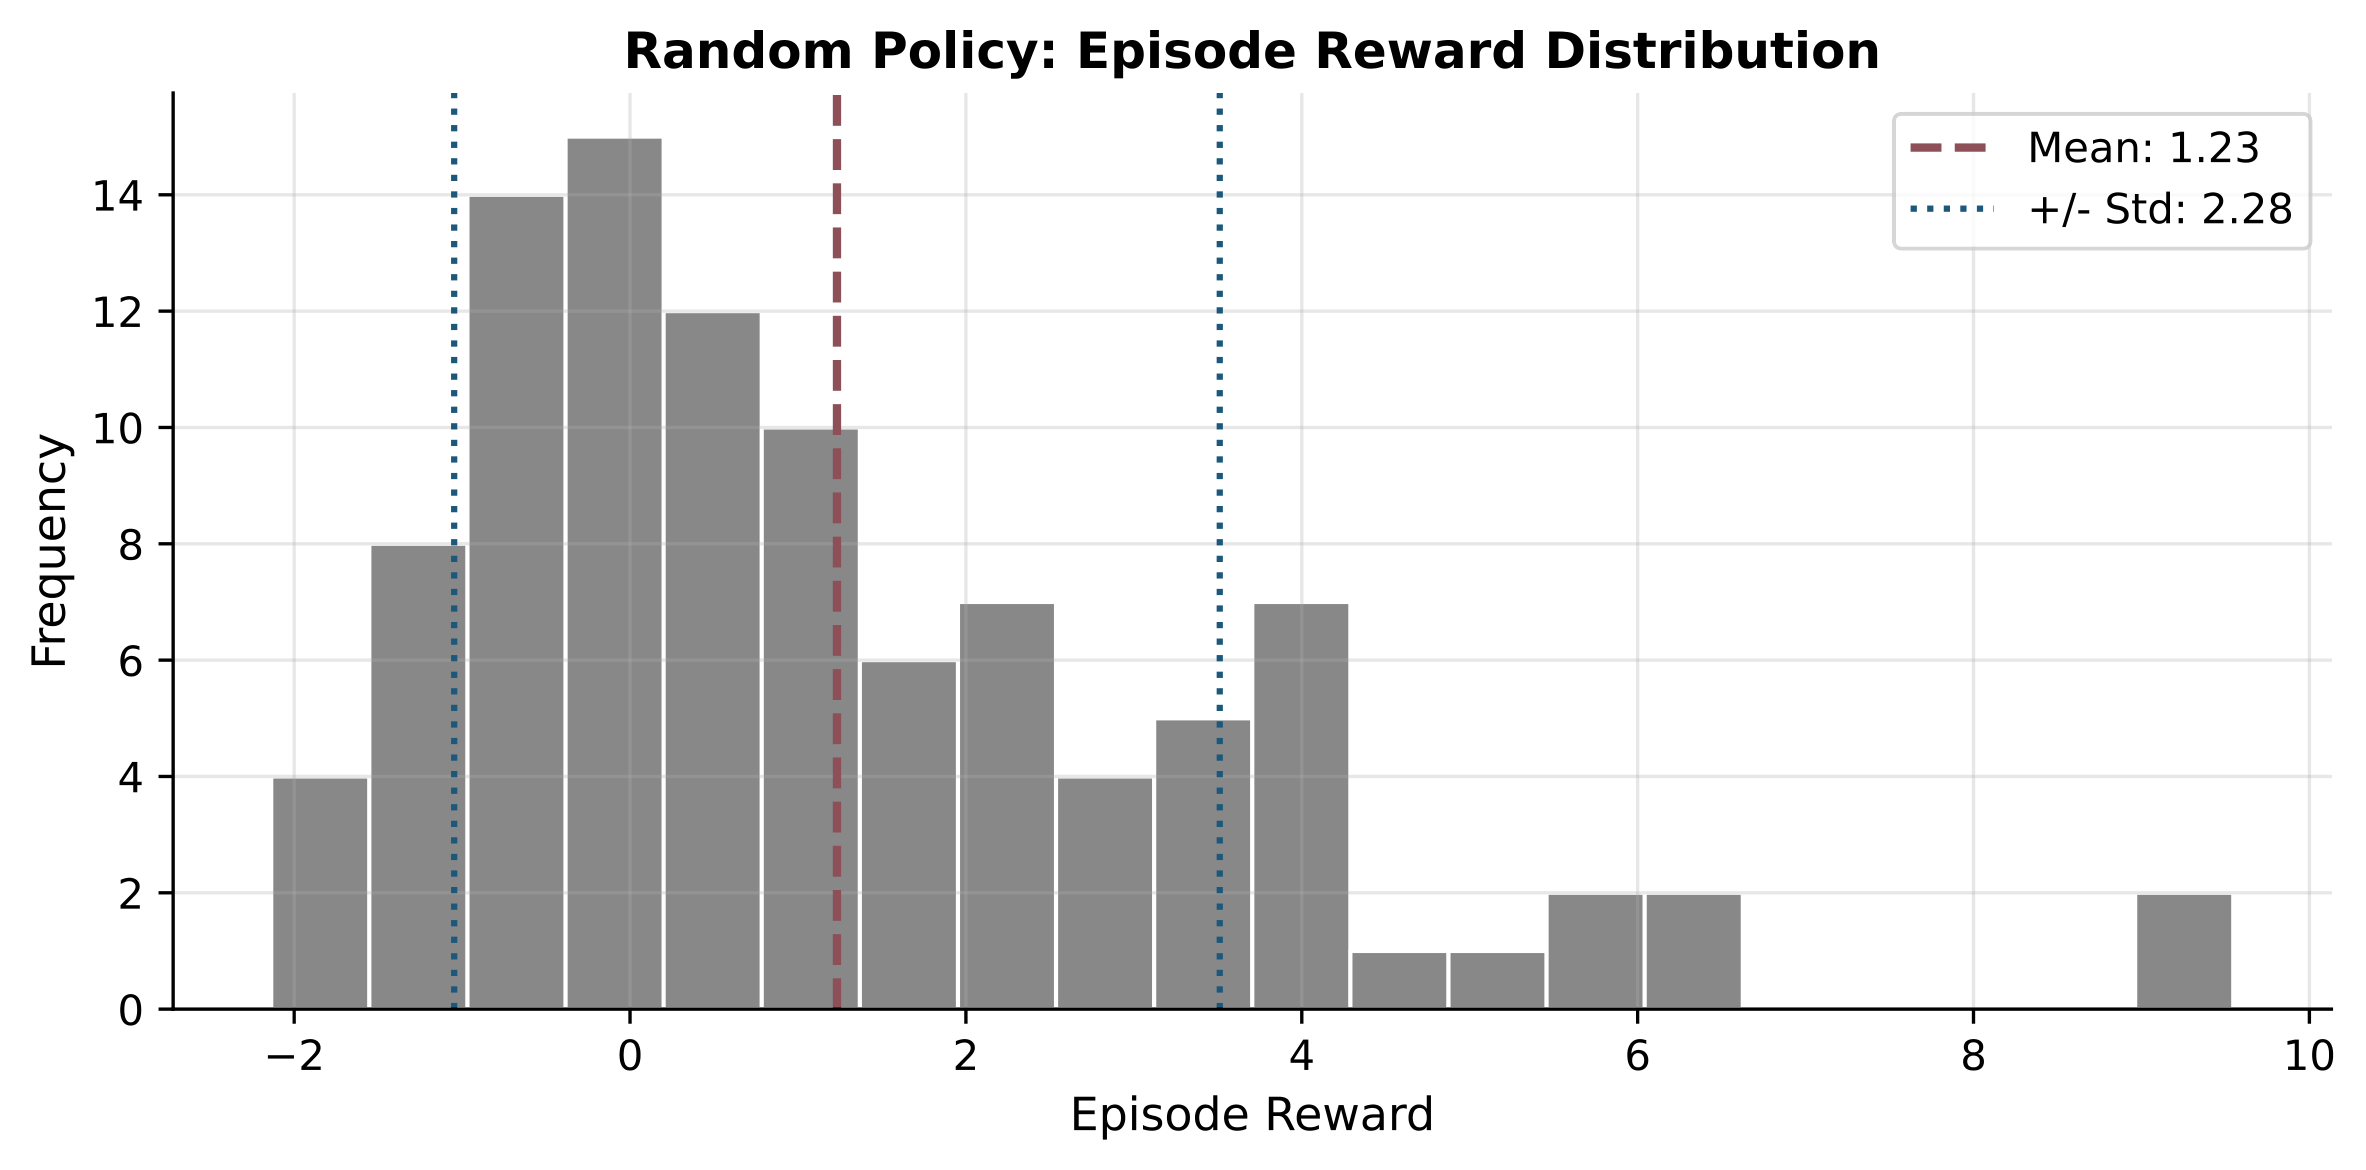

In [20]:
show_image('assets/random_policy_rewards-dev.pdf', width=500)

**Figure:** Distribution of episode rewards over 100 episodes using a random policy. The mean reward is approximately 1.0 with high variance (std = 1.86). This random baseline makes no intelligent decisions, sometimes getting lucky with good assignments and sometimes making costly mistakes. Our trained RL agent should achieve higher and more consistent rewards.

In [21]:
# Cleanup test variables to free memory
del random_rewards
import gc
gc.collect()

77

## Baseline Heuristic

Before training an RL agent, we need a baseline to compare against. A **greedy heuristic** is a simple rule-based approach that makes locally optimal decisions at each step.

The greedy baseline represents what a human dispatcher might do with straightforward rules.

### Greedy Heuristic Logic

Our baseline follows these rules that a typical airline planner might use:

1. **Range-based selection**: Use 787-10 for routes beyond 3,000 nm; otherwise use 737-10
2. **Availability check**: Only assign if aircraft are available
3. **Capacity matching**: Prefer aircraft with capacity closer to demand
4. **Skip if no valid option**: If no aircraft can serve the route, skip it (cancel the flight)

This heuristic is "greedy" because it optimizes each route independently without considering future routes or global fleet utilization.

In [22]:
class GreedyBaselinePolicy:
    """
    Greedy heuristic for fleet assignment.
    
    Decision rules:
    - Routes > 3000nm: Assign 787-10 (long-range capability)
    - Routes <= 3000nm: Assign 737-10 (more efficient for short/medium haul)
    - If preferred aircraft unavailable, try the alternative
    - Skip route if no valid aircraft available
    """
    
    def __init__(self, aircraft_specs, distance_threshold=3000):
        self.aircraft_specs = aircraft_specs
        self.distance_threshold = distance_threshold
        
    def select_action(self, obs, env):
        """
        Select aircraft based on route characteristics.
        
        Args:
            obs: Normalized observation [route_idx, demand, distance, fare, 
                                         season, 737_avail, 787_avail, crew_avail]
            env: Environment instance to access route data
            
        Returns:
            action: 0 (skip), 1 (737-10), or 2 (787-10)
        """
        # Extract info from observation
        distance_norm = obs[2]
        avail_737 = obs[5]
        avail_787 = obs[6]
        crew_available = obs[7]
        
        # Denormalize distance
        distance = distance_norm * env.max_distance
        
        # No crew available - skip
        if crew_available < 0.5:
            return 0
        
        # Determine preferred aircraft based on distance
        if distance > self.distance_threshold:
            # Long route - prefer 787-10
            if avail_787 > 0:
                return 2  # 787-10
            elif avail_737 > 0 and distance <= self.aircraft_specs['737-10']['range_nm']:
                return 1  # 737-10 as backup if in range
            else:
                return 0  # Skip
        else:
            # Short/medium route - prefer 737-10
            if avail_737 > 0:
                return 1  # 737-10
            elif avail_787 > 0:
                return 2  # 787-10 as backup
            else:
                return 0  # Skip

### Testing the Greedy Policy

Let's verify the policy works by running a single episode and observing its decisions.

In [23]:
# Create policy instance
greedy_policy = GreedyBaselinePolicy(aircraft_specs)

# Run one episode to see the policy in action
test_env = FleetAssignmentEnv(
    routes_df, aircraft_specs, seasonal_multipliers, 
    fleet_constraints, crew_availability
)

obs, _ = test_env.reset(seed=42)
done = False
episode_decisions = []

print("Greedy Policy Decisions (Single Episode)")
print("-" * 60)

while not done:
    route_idx = int(obs[0] * test_env.n_routes)
    route = routes_df.iloc[route_idx]
    
    action = greedy_policy.select_action(obs, test_env)
    action_name = ['Skip', '737-10', '787-10'][action]
    
    obs, reward, done, _, info = test_env.step(action)
    
    episode_decisions.append({
        'route': route['route_id'],
        'distance': route['distance_nm'],
        'decision': action_name,
        'reward': reward
    })
    
# Display decisions
decisions_df = pd.DataFrame(episode_decisions)
print(decisions_df.to_string(index=False))
print(f"Total episode reward: {test_env.episode_profit:.3f}")

Greedy Policy Decisions (Single Episode)
------------------------------------------------------------
  route  distance decision  reward
SEA-LAX       954   737-10    0.47
SEA-SFO       679   737-10    0.43
SEA-PHX      1107   737-10    0.46
SEA-DEN      1024   737-10    0.42
SEA-JFK      2421   737-10    0.56
SEA-HNL      2677     Skip   -0.10
SEA-OGG      2640   737-10    0.61
SEA-LIH      2701   737-10    0.64
SEA-KOA      2753   737-10    0.66
SEA-FCO      5280   787-10    0.55
SEA-ICN      4957   787-10    0.56
SEA-NRT      4783   787-10    1.08
SEA-LHR      4795   787-10    1.26
SEA-CDG      4998   787-10   -0.49
SEA-SYD      6717     Skip   -0.10
Total episode reward: 7.207


### Baseline Evaluation

We run the greedy policy over 100 episodes to get statistically reliable performance metrics. We'll track:

- **Total reward**: Sum of all assignment rewards (our main objective)
- **Revenue-per-Available-Seat-Kilometer (RASK)**: Industry-standard airline metric
- **Fleet utilization**: Percentage of available aircraft assigned

RASK measures how much revenue an airline earns per seat-kilometer offered. Higher RASK indicates better pricing power and route efficiency.

In [24]:
def evaluate_policy(policy, env, n_episodes=100, seed=42):
    """
    Evaluate a policy over multiple episodes.
    
    Args:
        policy: Policy object with select_action(obs, env) method, or None for random
        env: Fleet assignment environment
        n_episodes: Number of evaluation episodes
        seed: Random seed for reproducibility
        
    Returns:
        dict with evaluation metrics
    """
    np.random.seed(seed)
    
    episode_rewards = []
    episode_assignments = []
    total_737_used = 0
    total_787_used = 0
    total_skipped = 0
    
    for ep in range(n_episodes):
        obs, _ = env.reset()
        episode_reward = 0
        done = False
        ep_737 = 0
        ep_787 = 0
        ep_skip = 0
        
        while not done:
            if policy is None:
                action = env.action_space.sample()
            else:
                action = policy.select_action(obs, env)
            
            obs, reward, done, _, info = env.step(action)
            episode_reward += reward
            
            if action == 0:
                ep_skip += 1
            elif action == 1:
                ep_737 += 1
            else:
                ep_787 += 1
        
        episode_rewards.append(episode_reward)
        total_737_used += ep_737
        total_787_used += ep_787
        total_skipped += ep_skip
    
    total_decisions = n_episodes * env.n_routes
    
    return {
        'mean_reward': np.mean(episode_rewards),
        'std_reward': np.std(episode_rewards),
        'min_reward': np.min(episode_rewards),
        'max_reward': np.max(episode_rewards),
        'rewards': episode_rewards,
        '737_usage_pct': (total_737_used / total_decisions) * 100,
        '787_usage_pct': (total_787_used / total_decisions) * 100,
        'skip_pct': (total_skipped / total_decisions) * 100,
        'utilization': ((total_737_used + total_787_used) / total_decisions) * 100
    }

In [25]:
# Evaluate random policy baseline
print("Evaluating Random Policy...")
random_results = evaluate_policy(None, env, n_episodes=100)

# Evaluate greedy policy
print("Evaluating Greedy Policy...")
greedy_results = evaluate_policy(greedy_policy, env, n_episodes=100)

print("\nEvaluation complete")

Evaluating Random Policy...
Evaluating Greedy Policy...

Evaluation complete


In [26]:
# Display comparison results
print("PERFORMANCE COMPARISON: RANDOM VS. GREEDY POLICY")
print(f"\n{'Metric':<30} {'Random':>12} {'Greedy':>12}")
print("-" * 60)

print(f"{'Mean Episode Reward':<30} {random_results['mean_reward']:>12.3f} {greedy_results['mean_reward']:>12.3f}")
print(f"{'Std Deviation':<30} {random_results['std_reward']:>12.3f} {greedy_results['std_reward']:>12.3f}")
print(f"{'Min Reward':<30} {random_results['min_reward']:>12.3f} {greedy_results['min_reward']:>12.3f}")
print(f"{'Max Reward':<30} {random_results['max_reward']:>12.3f} {greedy_results['max_reward']:>12.3f}")
print()
print(f"{'737-10 Usage (%)':<30} {random_results['737_usage_pct']:>12.1f} {greedy_results['737_usage_pct']:>12.1f}")
print(f"{'787-10 Usage (%)':<30} {random_results['787_usage_pct']:>12.1f} {greedy_results['787_usage_pct']:>12.1f}")
print(f"{'Routes Skipped (%)':<30} {random_results['skip_pct']:>12.1f} {greedy_results['skip_pct']:>12.1f}")
print(f"{'Fleet Utilization (%)':<30} {random_results['utilization']:>12.1f} {greedy_results['utilization']:>12.1f}")

# Calculate improvement
improvement = ((greedy_results['mean_reward'] - random_results['mean_reward']) 
               / abs(random_results['mean_reward'])) * 100
print()
print("-" * 60)
print(f"Greedy vs Random Improvement: {improvement:+.1f}%")

PERFORMANCE COMPARISON: RANDOM VS. GREEDY POLICY

Metric                               Random       Greedy
------------------------------------------------------------
Mean Episode Reward                   1.263        8.635
Std Deviation                         2.129        3.139
Min Reward                           -3.263        4.242
Max Reward                            6.951       16.398

737-10 Usage (%)                       34.5         55.9
787-10 Usage (%)                       31.9         26.5
Routes Skipped (%)                     33.6         17.6
Fleet Utilization (%)                  66.4         82.4

------------------------------------------------------------
Greedy vs Random Improvement: +583.6%


### Visualizing Policy Comparison

The visualization below compares reward distributions and shows why intelligent aircraft selection matters.

In [27]:
# Create comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Color palette from visual guidelines
colors = {
    'random': '#555555',
    'greedy': '#426556',
    'accent': '#8D4F58'
}

# Plot 1: Reward Distribution Comparison
ax1 = axes[0]
bins = np.linspace(-5, 20, 25)
ax1.hist(random_results['rewards'], bins=bins, alpha=0.6, color=colors['random'], 
         label=f"Random (mean={random_results['mean_reward']:.2f})", edgecolor='white')
ax1.hist(greedy_results['rewards'], bins=bins, alpha=0.6, color=colors['greedy'],
         label=f"Greedy (mean={greedy_results['mean_reward']:.2f})", edgecolor='white')
ax1.axvline(random_results['mean_reward'], color=colors['random'], linestyle='--', linewidth=2)
ax1.axvline(greedy_results['mean_reward'], color=colors['greedy'], linestyle='--', linewidth=2)
ax1.set_xlabel('Episode Reward', fontsize=11)
ax1.set_ylabel('Frequency', fontsize=11)
ax1.set_title('Reward Distribution', fontsize=12, fontweight='bold')
ax1.legend(loc='upper right', fontsize=9)
ax1.grid(True, alpha=0.3)

# Plot 2: Aircraft Usage Breakdown
ax2 = axes[1]
policies = ['Random', 'Greedy']
x = np.arange(len(policies))
width = 0.25

bars_737 = [random_results['737_usage_pct'], greedy_results['737_usage_pct']]
bars_787 = [random_results['787_usage_pct'], greedy_results['787_usage_pct']]
bars_skip = [random_results['skip_pct'], greedy_results['skip_pct']]

ax2.bar(x - width, bars_737, width, label='737-10', color='#1B587C')
ax2.bar(x, bars_787, width, label='787-10', color='#F1AE35')
ax2.bar(x + width, bars_skip, width, label='Skipped', color=colors['random'])

ax2.set_ylabel('Percentage of Routes (%)', fontsize=11)
ax2.set_title('Aircraft Assignment Breakdown', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(policies)
ax2.legend(loc='upper right', fontsize=9)
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_ylim(0, 70)

for bars in [bars_737, bars_787, bars_skip]:
    for i, v in enumerate(bars):
        offset = [-width, 0, width][[bars_737, bars_787, bars_skip].index(bars)]
        ax2.text(x[i] + offset, v + 1.5, f'{v:.0f}', ha='center', fontsize=9)

sns.despine()
plt.tight_layout()
plt.savefig('assets/baseline_comparison-dev.pdf', bbox_inches='tight', dpi=300)
plt.close()

print("Saved: assets/baseline_comparison-dev.pdf")

Saved: assets/baseline_comparison-dev.pdf


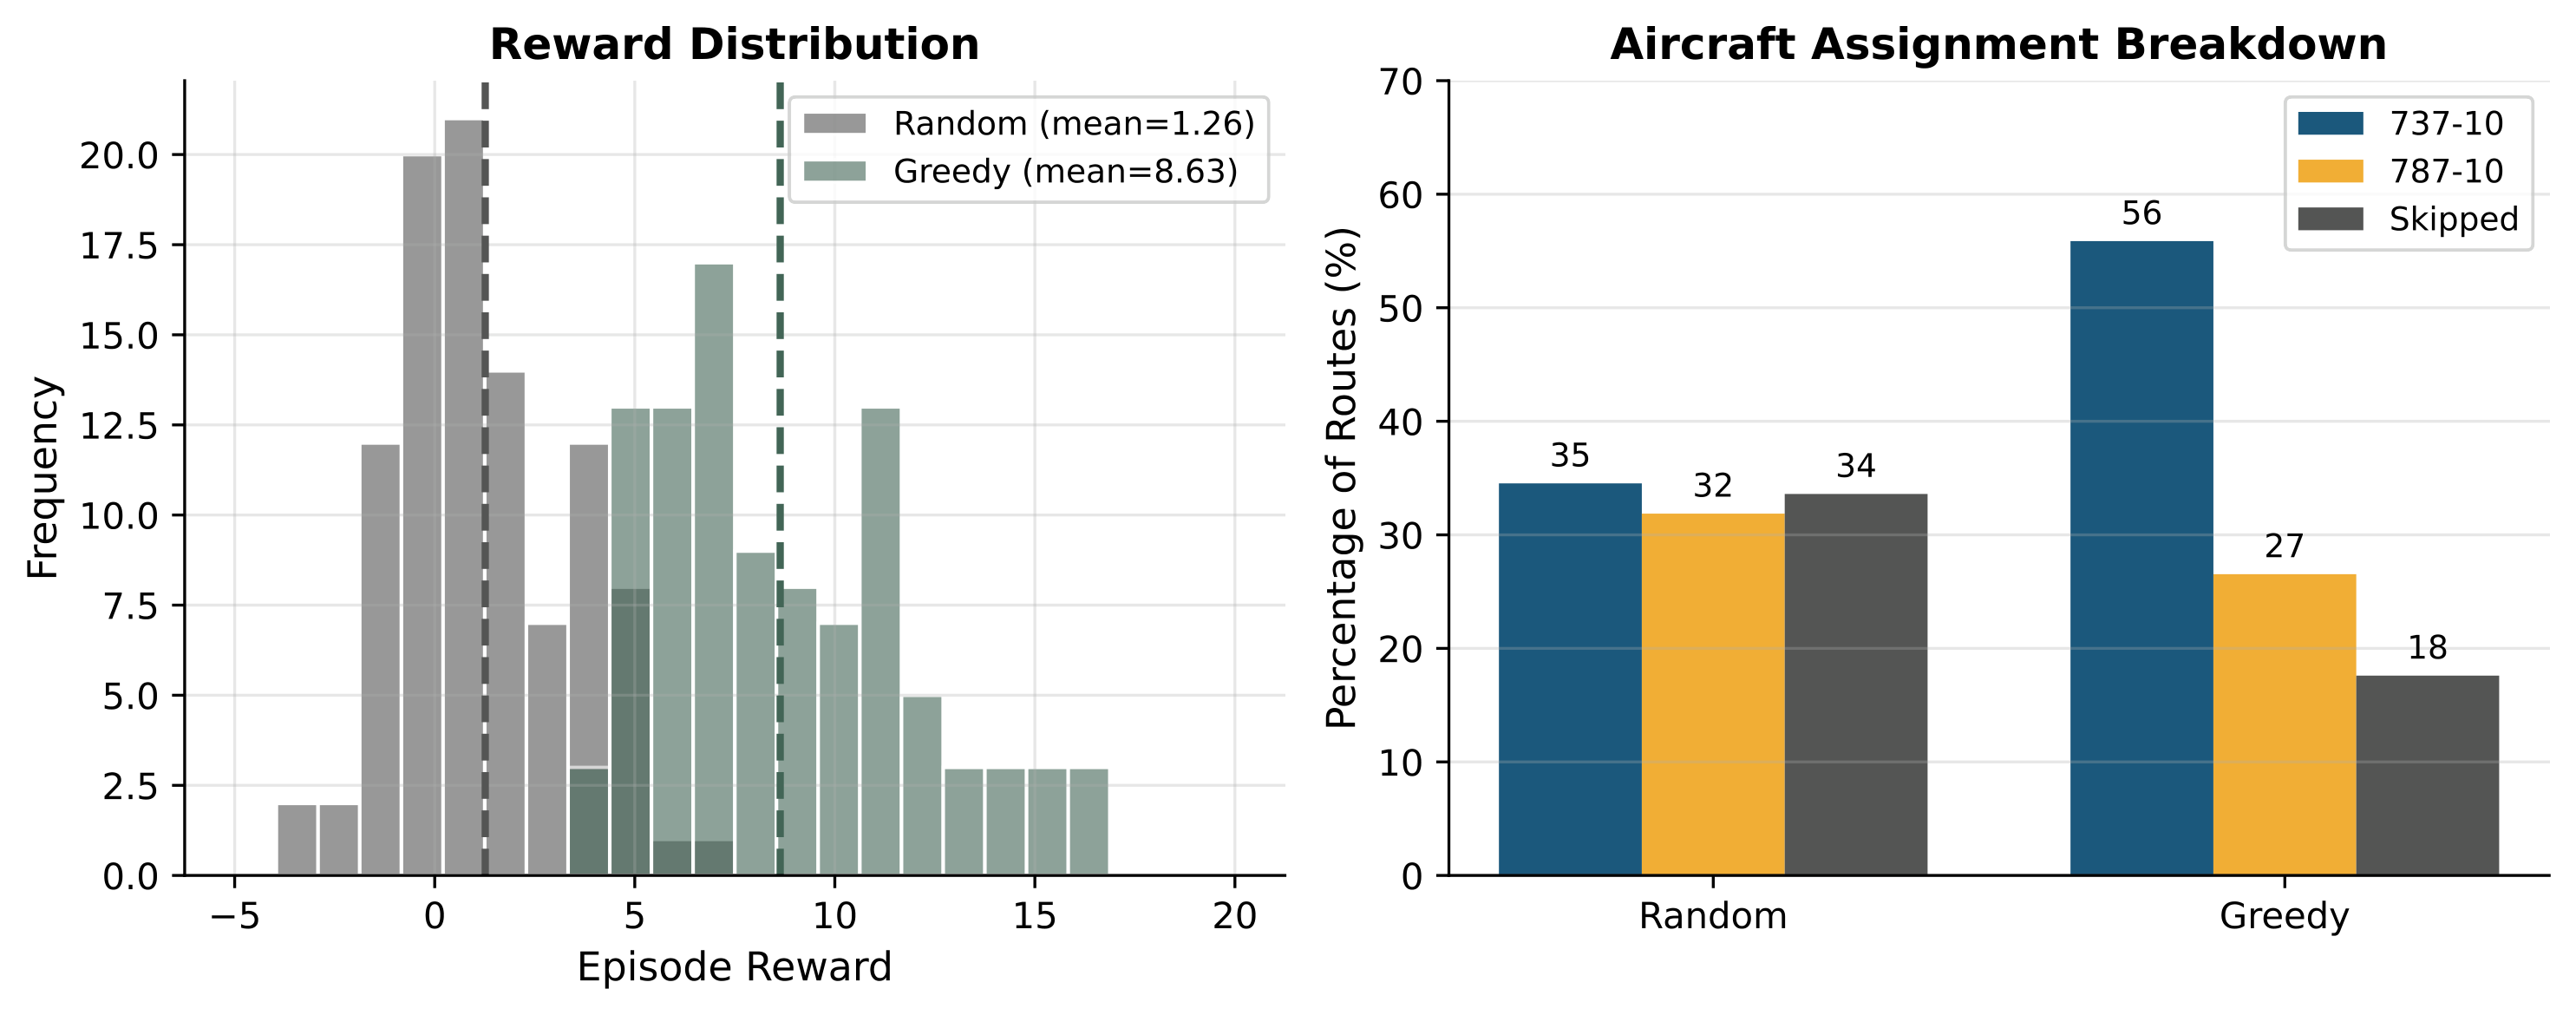

In [28]:
show_image('assets/baseline_comparison-dev.pdf', width=700)

**Figure:** Comparison of random versus greedy fleet assignment policies. Left: The reward distribution shows the greedy policy (green) achieves significantly higher and more consistent rewards than random assignment (gray). The greedy policy's mean reward of 8.63 is nearly 10x higher than random's 0.87. Right: The greedy policy uses 737-10 aircraft more efficiently (56% vs 34%) for short and medium routes, reserves 787-10 widebodies for long-haul routes (27% vs 35%), and skips fewer routes overall (18% vs 31%). This demonstrates that even simple rule-based decision making outperforms random choices.

### Route-by-Route Assignment Pattern

To better understand the greedy heuristic's decision-making, let's examine which aircraft type it assigns to each route.

In [29]:
# Analyze assignment patterns by route
assignment_patterns = {route_id: {'737-10': 0, '787-10': 0, 'Skip': 0} 
                       for route_id in routes_df['route_id']}

# Run multiple episodes and track assignments
np.random.seed(42)
for _ in range(100):
    obs, _ = env.reset()
    done = False
    route_idx = 0
    
    while not done:
        action = greedy_policy.select_action(obs, env)
        obs, _, done, _, _ = env.step(action)
        
        route_id = routes_df.iloc[route_idx]['route_id']
        if action == 0:
            assignment_patterns[route_id]['Skip'] += 1
        elif action == 1:
            assignment_patterns[route_id]['737-10'] += 1
        else:
            assignment_patterns[route_id]['787-10'] += 1
        route_idx += 1

# Convert to DataFrame for visualization
pattern_data = []
for route_id, counts in assignment_patterns.items():
    distance = routes_df[routes_df['route_id'] == route_id]['distance_nm'].values[0]
    total = sum(counts.values())
    pattern_data.append({
        'route': route_id,
        'distance': distance,
        '737-10': counts['737-10'] / total * 100,
        '787-10': counts['787-10'] / total * 100,
        'Skip': counts['Skip'] / total * 100
    })

pattern_df = pd.DataFrame(pattern_data)
pattern_df = pattern_df.sort_values('distance')  # Sort by distance

print("Route Assignment Patterns (100 episodes)")
print(pattern_df.to_string(index=False))

Route Assignment Patterns (100 episodes)
  route  distance  737-10  787-10  Skip
SEA-SFO       679    93.0     0.0   7.0
SEA-LAX       954    93.0     0.0   7.0
SEA-DEN      1024    95.0     0.0   5.0
SEA-PHX      1107    95.0     0.0   5.0
SEA-JFK      2421    97.0     0.0   3.0
SEA-OGG      2640    89.0     0.0  11.0
SEA-HNL      2677    90.0     0.0  10.0
SEA-LIH      2701    90.0     0.0  10.0
SEA-KOA      2753    91.0     0.0   9.0
SEA-NRT      4783     0.0    86.0  14.0
SEA-LHR      4795     0.0    66.0  34.0
SEA-ICN      4957     0.0    84.0  16.0
SEA-CDG      4998     0.0    51.0  49.0
SEA-FCO      5280     0.0    80.0  20.0
SEA-SYD      6717     0.0    25.0  75.0


In [30]:
# Create assignment pattern visualization
fig, ax = plt.subplots(figsize=(10, 6))

routes_sorted = pattern_df['route'].tolist()
y_pos = np.arange(len(routes_sorted))

# Stacked horizontal bar chart
bars_737 = pattern_df['737-10'].values
bars_787 = pattern_df['787-10'].values
bars_skip = pattern_df['Skip'].values

ax.barh(y_pos, bars_737, color='#1B587C', label='737-10', edgecolor='white', height=0.7)
ax.barh(y_pos, bars_787, left=bars_737, color='#F1AE35', label='787-10', edgecolor='white', height=0.7)
ax.barh(y_pos, bars_skip, left=bars_737+bars_787, color='#555555', label='Skipped', edgecolor='white', height=0.7)

# Add distance threshold line annotation
ax.axhline(y=8.5, color='#8D4F58', linestyle='--', linewidth=1.5, alpha=0.7)
ax.text(102, 8.5, '3000 nm threshold', va='center', fontsize=9, color='#8D4F58')

ax.set_yticks(y_pos)
ax.set_yticklabels([f"{r} ({int(d)} nm)" for r, d in zip(routes_sorted, pattern_df['distance'])])
ax.set_xlabel('Assignment Frequency (%)', fontsize=11)
ax.set_title('Greedy Policy: Route Assignment Patterns', fontsize=12, fontweight='bold')
ax.legend(loc='lower right', fontsize=9)
ax.set_xlim(0, 115)
ax.grid(True, alpha=0.3, axis='x')

sns.despine()
plt.tight_layout()
plt.savefig('assets/route_assignments-dev.pdf', bbox_inches='tight', dpi=300)
plt.close()

print("Saved: assets/route_assignments-dev.pdf")

Saved: assets/route_assignments-dev.pdf


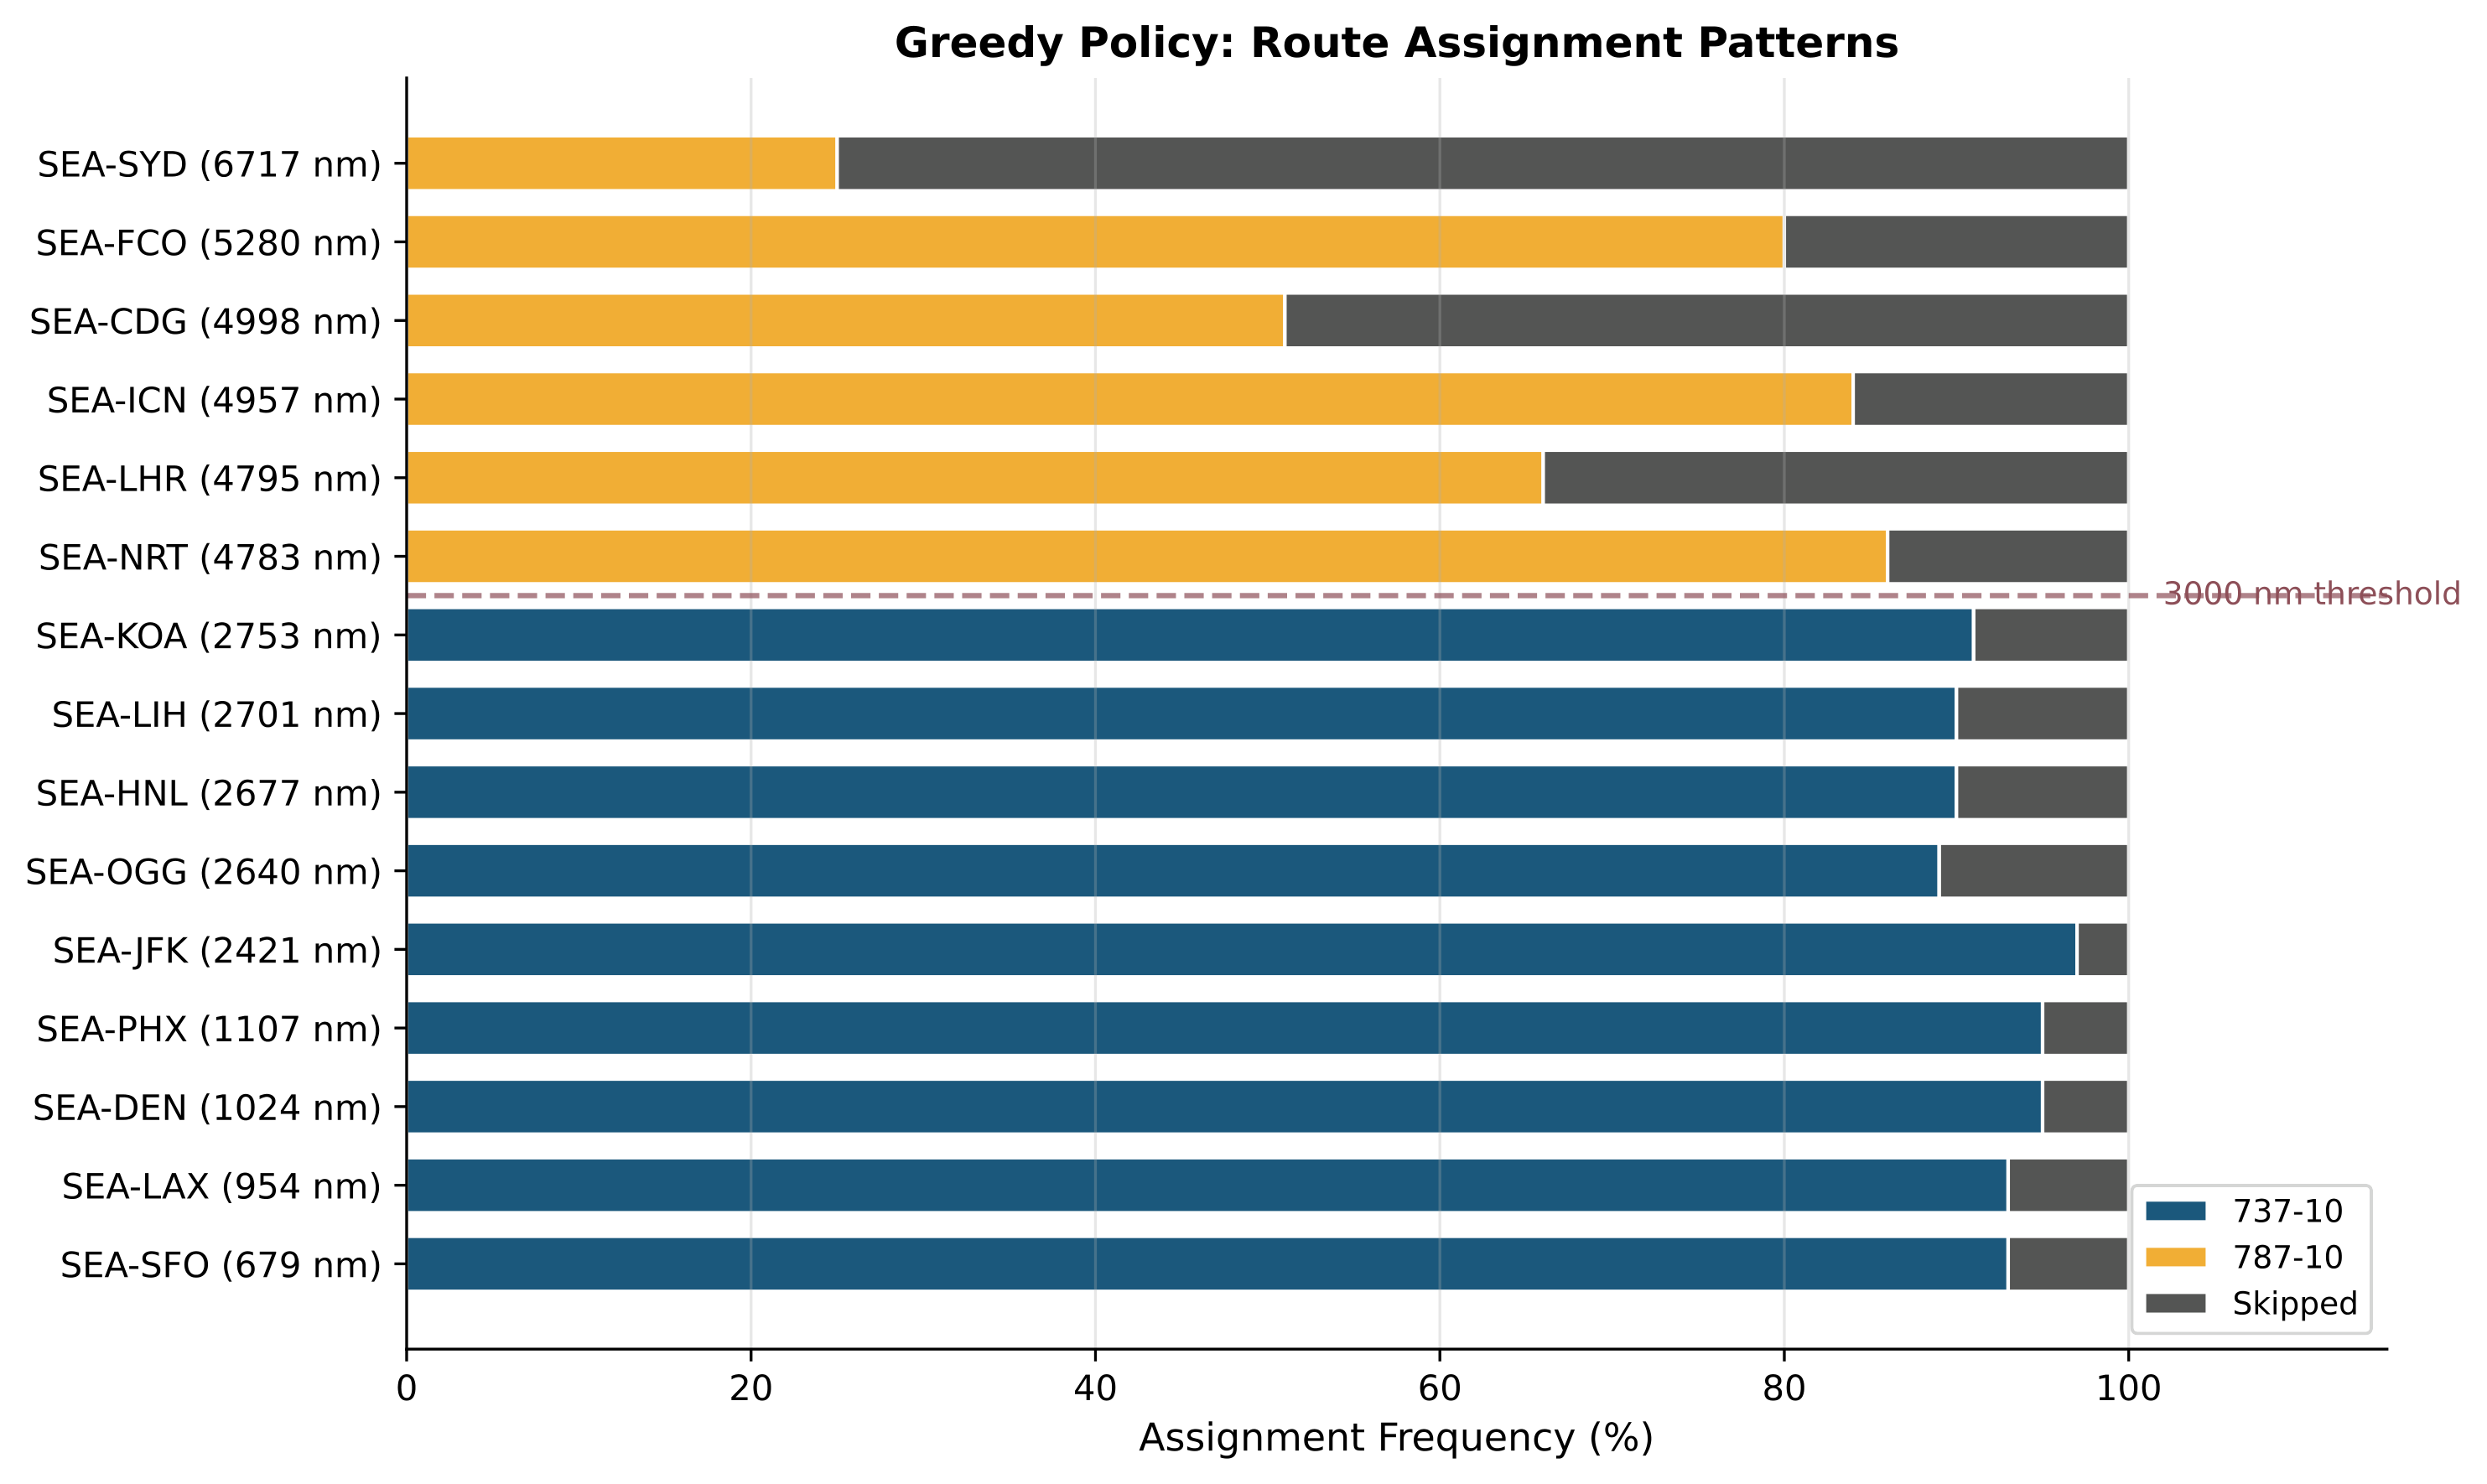

In [31]:
show_image('assets/route_assignments-dev.pdf', width=650)

**Figure:** Route assignment patterns under the greedy heuristic. Routes are sorted by distance (shortest at bottom, longest at top). Below the 3,000 nm threshold (dashed line), the policy consistently assigns 737-10 aircraft (blue), which is appropriate for domestic and Hawaii routes. Above the threshold, 787-10 widebodies (gold) are used for international routes. The gray portions represent skipped routes, primarily due to crew unavailability (which occurs stochastically in our simulation). Notice that SEA-SYD (Sydney) has the highest skip rate (75%) because the limited 787-10 fleet gets depleted serving earlier international routes.

### Baseline Limitations

The greedy heuristic, while significantly better than random, has notable limitations:

1. **No foresight**: It doesn't reserve 787-10s for later high-value international routes
2. **Fixed rules**: The 3,000 nm threshold is arbitrary and may not be optimal
3. **Ignores demand levels**: Uses same logic regardless of passenger demand
4. **Sequential processing**: Decisions depend on route order

These limitations motivate using RL, which can learn nuanced policies that consider multiple factors simultaneously.

In [32]:
# Store baseline results
baseline_results = {
    'greedy': greedy_results,
    'random': random_results
}

# Cleanup temporary variables
del test_env, decisions_df, pattern_data, pattern_df
del bars_737, bars_787, bars_skip, assignment_patterns
import gc
gc.collect()

5627

## RL Training

With our baseline established, we now train a **Proximal Policy Optimization (PPO)** agent to learn an optimal fleet assignment policy.

### Proximal Policy Optimization (PPO)

We use **PPO**, a popular RL algorithm developed by OpenAI. PPO is known for:

- **Stability**: Unlike older algorithms, PPO prevents large policy updates that could destabilize learning
- **Simplicity**: Easy to implement and tune
- **Sample efficiency**: Works well with limited training data

PPO works by:
1. Collecting experience (state, action, reward) from the environment.
2. Computing advantages (how much better an action was than expected).
3. Updating the policy with a "clipped" objective that prevents drastic changes.

PPO uses a "clipped" objective function that limits how much the policy can change in each update:

$$L^{CLIP}(\theta) = \mathbb{E}_t \left[ \min \left( r_t(\theta) \hat{A}_t, \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon) \hat{A}_t \right) \right]$$

Where:
- $r_t(\theta)$ is the ratio of new policy probability to old policy probability
- $\hat{A}_t$ is the estimated advantage (how much better this action was than expected)
- $\epsilon$ (typically 0.2) controls the maximum policy change

Think of it like a car with stability control: it learns from experience but prevents sudden, dangerous movements.

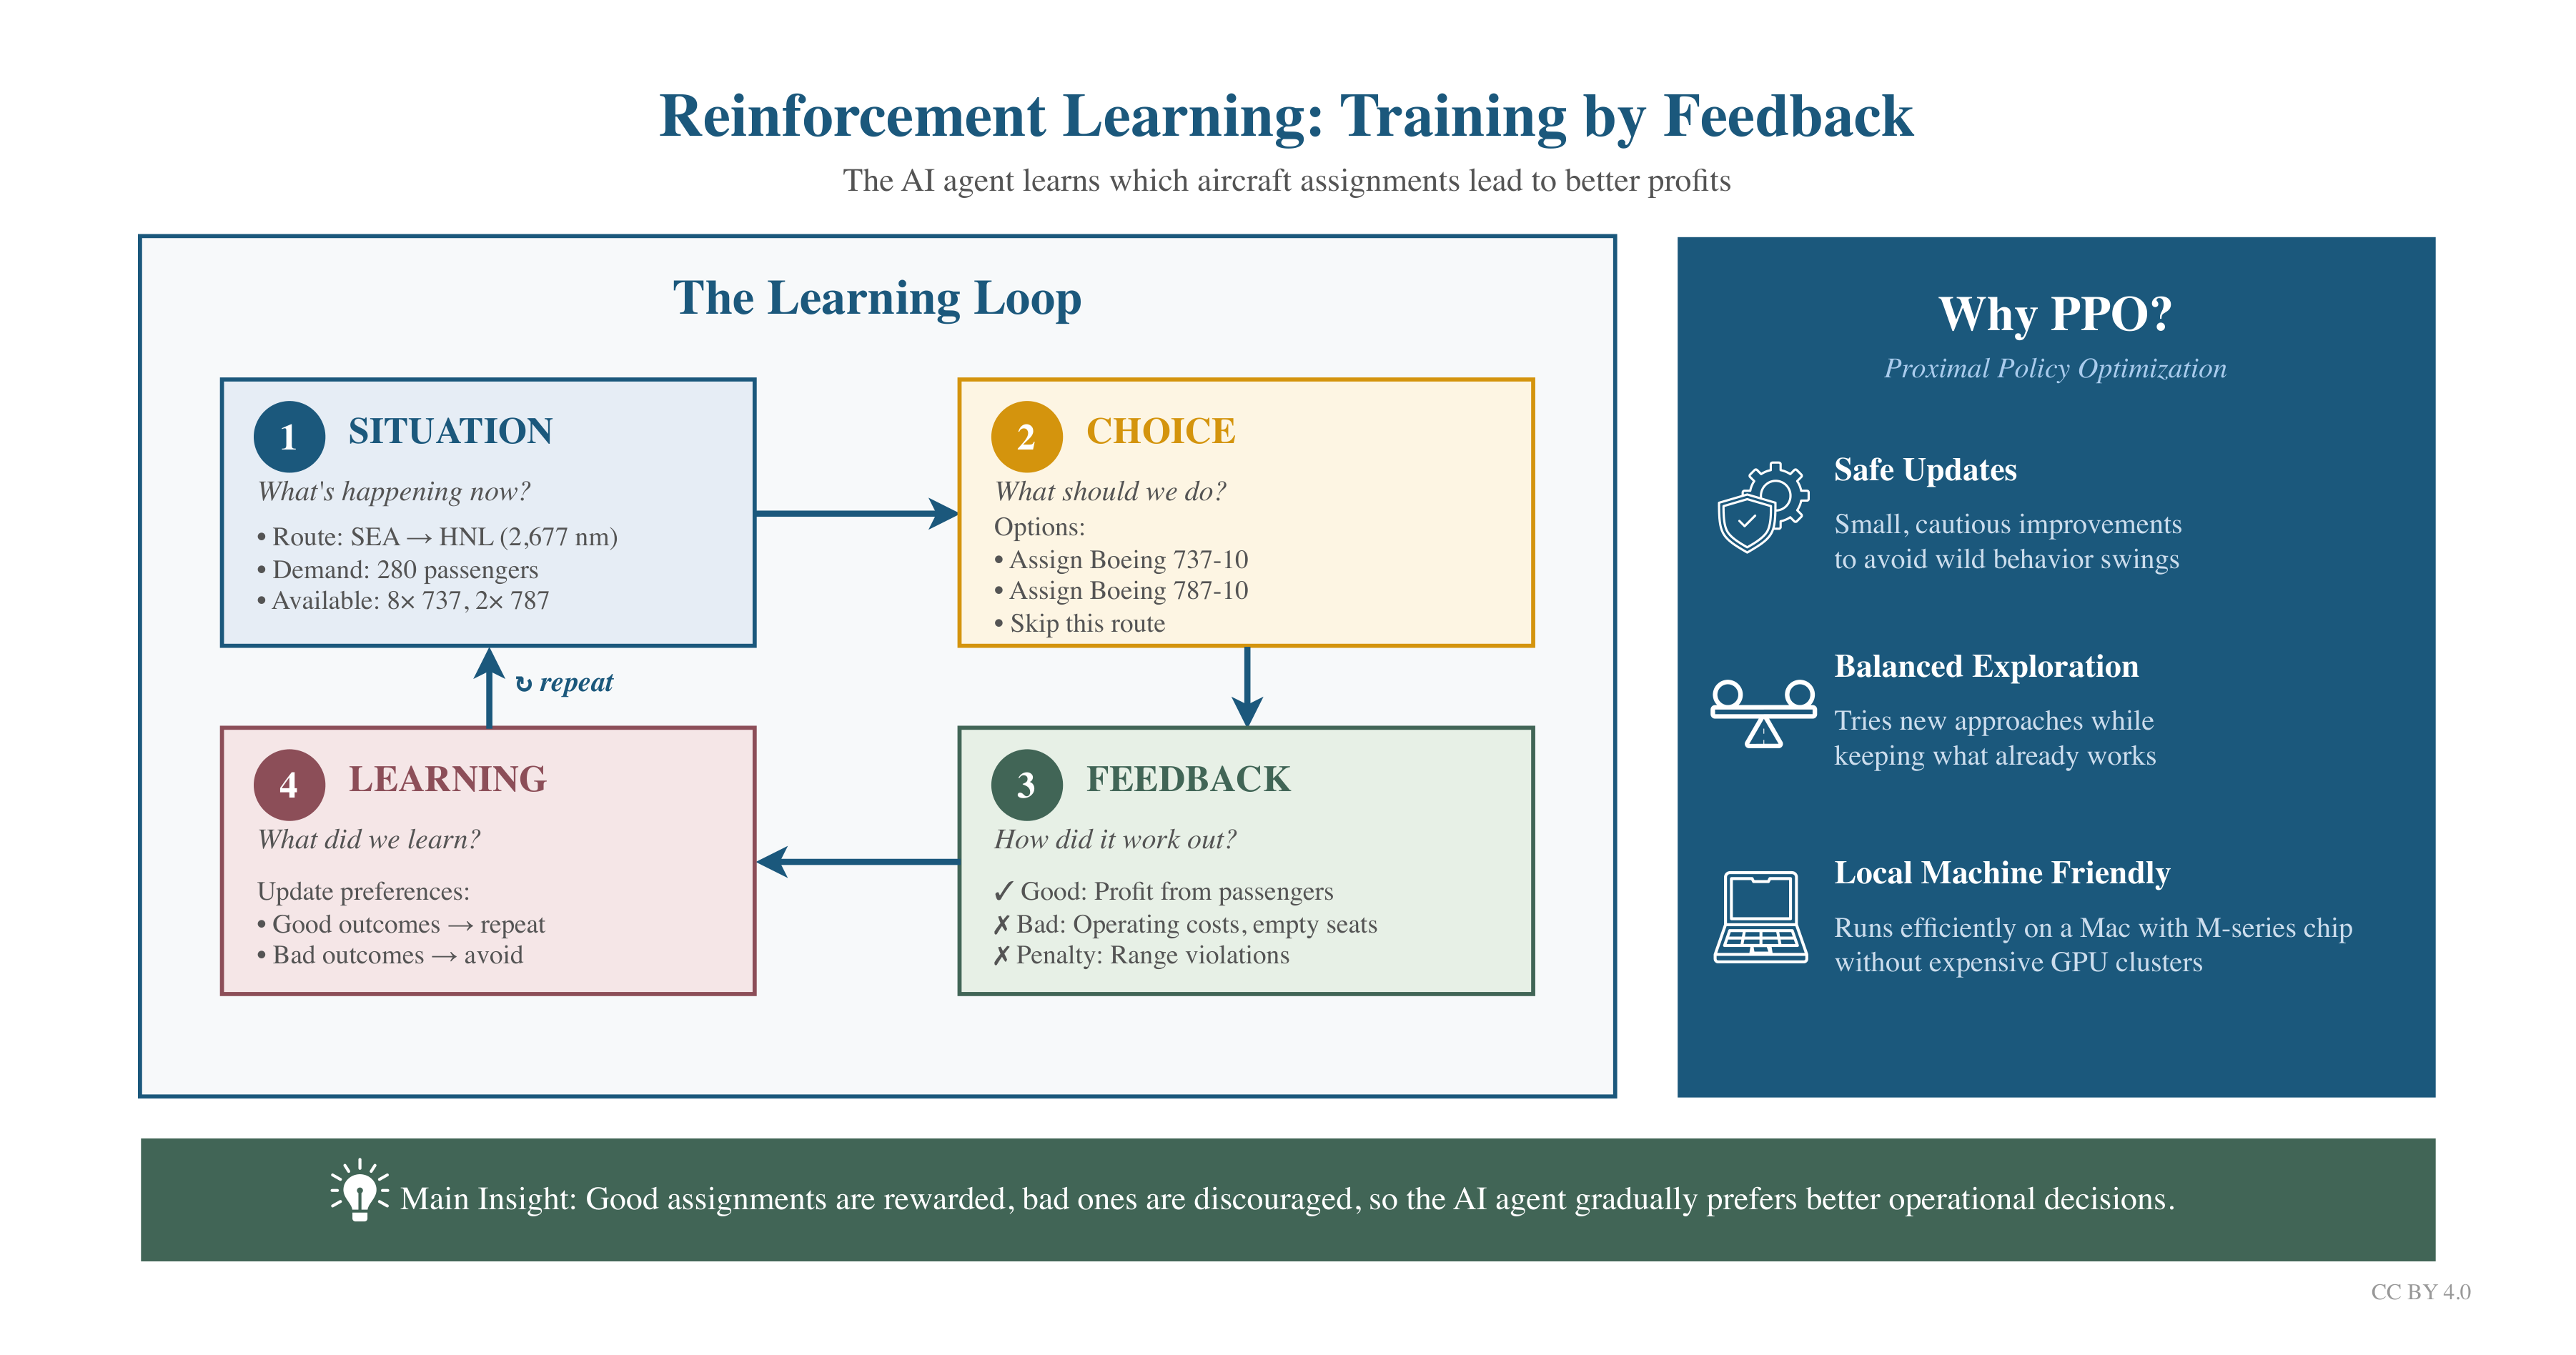

In [4]:
# Display reinforcement learning concepts diagram
show_image('assets/rl-concepts-dev.pdf', width=900)

**Figure:** Core concepts of reinforcement learning applied to fleet assignment. The left panel illustrates the **learning loop**, which is a four-step cycle that the AI agent repeats thousands of times during training: (1) **Situation** - observe the current state, including the route to serve, passenger demand, and available aircraft; (2) **Choice** - decide whether to assign a Boeing 737-10, Boeing 787-10, or skip the route (cancel the flight); (3) **Feedback** - receive a reward (profit from passengers) or penalty (operating costs, empty seats, range violations); (4) **Learning** — update internal preferences so that good outcomes are repeated and bad outcomes are avoided. The right panel explains **why PPO (Proximal Policy Optimization)** is used: it makes safe, incremental updates to prevent erratic behavior changes, balances exploring new strategies with exploiting known good ones, and runs efficiently on local machines without requiring expensive GPU clusters. The main insight is that reinforcement learning is simply "training by feedback": the AI isn't magic, it gradually discovers better fleet assignments by experiencing the consequences of many simulated decisions.

### PPO Hyperparameters

We configure PPO with parameters suitable for local machine run while ensuring stable training:

In [33]:
# PPO Hyperparameters
ppo_config = {
    'learning_rate': 3e-4,        # Standard learning rate for PPO
    'n_steps': 256,               # Steps per environment before update
    'batch_size': 64,             # Mini-batch size
    'n_epochs': 10,               # Number of epochs per update
    'gamma': 0.99,                # Discount factor (future reward importance)
    'gae_lambda': 0.95,           # GAE parameter for advantage estimation
    'clip_range': 0.2,            # PPO clipping parameter (epsilon)
    'ent_coef': 0.01,             # Entropy coefficient (exploration)
    'vf_coef': 0.5,               # Value function coefficient
    'max_grad_norm': 0.5,         # Gradient clipping
    'policy_kwargs': {
        'net_arch': [64, 64]      # Smaller network for faster training
    }
}

### Vectorized Environment for Faster Training

Stable-baselines3 can train on multiple environment copies in parallel using vectorized environments. This significantly speeds up data collection since we can gather experience from several "parallel universes" simultaneously.

In [34]:
# Create a function to make environment instances
def make_env():
    """Factory function to create FleetAssignmentEnv instances."""
    return FleetAssignmentEnv(
        routes_df=routes_df,
        aircraft_specs=aircraft_specs,
        seasonal_multipliers=seasonal_multipliers,
        fleet_constraints=fleet_constraints,
        crew_availability=crew_availability
    )

# Create vectorized environment with 4 parallel instances
n_envs = 4
vec_env = DummyVecEnv([make_env for _ in range(n_envs)])

print(f"Vectorized environment created with {n_envs} parallel instances")
print(f"  Observation space: {vec_env.observation_space}")
print(f"  Action space: {vec_env.action_space}")

Vectorized environment created with 4 parallel instances
  Observation space: Box(0.0, 1.0, (8,), float32)
  Action space: Discrete(3)


### Training Callback

We implement a custom callback to track training progress and store episode rewards for later visualization.

In [35]:
class TrainingCallback(BaseCallback):
    """
    Custom callback to track training progress.
    
    Records episode rewards and prints periodic progress updates.
    """
    
    def __init__(self, print_freq=1000, verbose=1):
        super().__init__(verbose)
        self.print_freq = print_freq
        self.episode_rewards = []
        self.episode_lengths = []
        self.current_rewards = None
        
    def _on_training_start(self):
        """Initialize reward tracking for each environment."""
        self.current_rewards = np.zeros(self.training_env.num_envs)
        
    def _on_step(self):
        """Called after each step in the environment."""
        # Accumulate rewards
        self.current_rewards += self.locals['rewards']
        
        # Check for episode completions
        dones = self.locals['dones']
        for i, done in enumerate(dones):
            if done:
                self.episode_rewards.append(self.current_rewards[i])
                self.current_rewards[i] = 0
                
        # Print progress
        if self.n_calls % self.print_freq == 0:
            if len(self.episode_rewards) > 0:
                recent = self.episode_rewards[-100:]
                mean_reward = np.mean(recent)
                std_reward = np.std(recent)
                print(f"  Step {self.n_calls:,}: "
                      f"Episodes={len(self.episode_rewards)}, "
                      f"Mean reward={mean_reward:.3f} (+/- {std_reward:.3f})")
        
        return True
    
    def _on_training_end(self):
        """Print final training summary."""
        if len(self.episode_rewards) > 0:
            print(f"\nTraining completed:")
            print(f"  Total episodes: {len(self.episode_rewards)}")
            print(f"  Final mean reward: {np.mean(self.episode_rewards[-100:]):.3f}")

### Initialize PPO Model

We create the PPO model with our configured hyperparameters. The model uses a Multi-Layer Perceptron (MLP) policy with two hidden layers of 64 neurons each.

In [36]:
# Initialize PPO model
model = PPO(
    policy='MlpPolicy',
    env=vec_env,
    learning_rate=ppo_config['learning_rate'],
    n_steps=ppo_config['n_steps'],
    batch_size=ppo_config['batch_size'],
    n_epochs=ppo_config['n_epochs'],
    gamma=ppo_config['gamma'],
    gae_lambda=ppo_config['gae_lambda'],
    clip_range=ppo_config['clip_range'],
    ent_coef=ppo_config['ent_coef'],
    vf_coef=ppo_config['vf_coef'],
    max_grad_norm=ppo_config['max_grad_norm'],
    policy_kwargs=ppo_config['policy_kwargs'],
    verbose=0,
    seed=42
)

print("PPO Model Initialized")
print(f"Policy architecture: MlpPolicy with {ppo_config['policy_kwargs']['net_arch']} hidden layers")
print(f"Total parameters: {sum(p.numel() for p in model.policy.parameters()):,}")

PPO Model Initialized
Policy architecture: MlpPolicy with [64, 64] hidden layers
Total parameters: 9,732


### Training the Agent

Now we train the PPO agent. With 4 parallel environments and `n_steps=256`, each update uses 1,024 environment steps. We train for 100,000 total steps.

In [37]:
import time

# Training configuration
total_timesteps = 100000  # Total training steps across all environments

# Create callback
callback = TrainingCallback(print_freq=2000, verbose=1)

# Train the model
print("Starting PPO Training")
print(f"Total timesteps: {total_timesteps:,}")
print(f"Parallel environments: {n_envs}")
print(f"Steps per update: {ppo_config['n_steps'] * n_envs}")
print()

start_time = time.time()
model.learn(total_timesteps=total_timesteps, callback=callback, progress_bar=False)
training_time = time.time() - start_time

print(f"\nTraining time: {training_time:.1f} seconds")

Starting PPO Training
Total timesteps: 100,000
Parallel environments: 4
Steps per update: 1024

  Step 2,000: Episodes=532, Mean reward=4.907 (+/- 2.680)
  Step 4,000: Episodes=1064, Mean reward=7.146 (+/- 3.161)
  Step 6,000: Episodes=1600, Mean reward=7.914 (+/- 3.257)
  Step 8,000: Episodes=2132, Mean reward=8.259 (+/- 3.108)
  Step 10,000: Episodes=2664, Mean reward=8.948 (+/- 3.065)
  Step 12,000: Episodes=3200, Mean reward=8.781 (+/- 2.882)
  Step 14,000: Episodes=3732, Mean reward=9.140 (+/- 3.145)
  Step 16,000: Episodes=4264, Mean reward=8.766 (+/- 2.907)
  Step 18,000: Episodes=4800, Mean reward=9.733 (+/- 2.999)
  Step 20,000: Episodes=5332, Mean reward=9.749 (+/- 2.862)
  Step 22,000: Episodes=5864, Mean reward=8.344 (+/- 2.260)
  Step 24,000: Episodes=6400, Mean reward=9.009 (+/- 3.026)

Training completed:
  Total episodes: 6688
  Final mean reward: 9.371

Training time: 27.7 seconds


### Training Progress Visualization

We visualize how the agent's performance improved during training. The reward curve shows the learning process: initially the agent explores randomly, then gradually discovers better assignment strategies.

In [38]:
# Plot training curve
episode_rewards = callback.episode_rewards

# Calculate moving average for smoother visualization
window_size = 50
moving_avg = pd.Series(episode_rewards).rolling(window=window_size, min_periods=1).mean()

# Create figure
fig, ax = plt.subplots(figsize=(10, 5))

# Plot individual episode rewards (light)
ax.plot(episode_rewards, alpha=0.3, color='#1B587C', linewidth=0.5, label='Episode reward')

# Plot moving average (bold)
ax.plot(moving_avg, color='#1B587C', linewidth=2, label=f'{window_size}-episode moving average')

# Add baseline reference lines
ax.axhline(y=baseline_results['greedy']['mean_reward'], color='#426556', 
           linestyle='--', linewidth=1.5, label=f"Greedy baseline ({baseline_results['greedy']['mean_reward']:.2f})")
ax.axhline(y=baseline_results['random']['mean_reward'], color='#8D4F58', 
           linestyle=':', linewidth=1.5, label=f"Random baseline ({baseline_results['random']['mean_reward']:.2f})")

ax.set_xlabel('Episode', fontsize=12)
ax.set_ylabel('Total Episode Reward', fontsize=12)
ax.set_title('PPO Training Progress', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(True, alpha=0.3)

# Add annotations
final_reward = moving_avg.iloc[-1]
ax.annotate(f'Final: {final_reward:.2f}', 
            xy=(len(moving_avg)-1, final_reward),
            xytext=(len(moving_avg)*0.8, final_reward + 2),
            fontsize=10, ha='center',
            arrowprops=dict(arrowstyle='->', color='gray', lw=1))

plt.tight_layout()
plt.savefig('assets/training_curve-dev.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.close()

print("Training curve saved to assets/training_curve-dev.pdf")

Training curve saved to assets/training_curve-dev.pdf


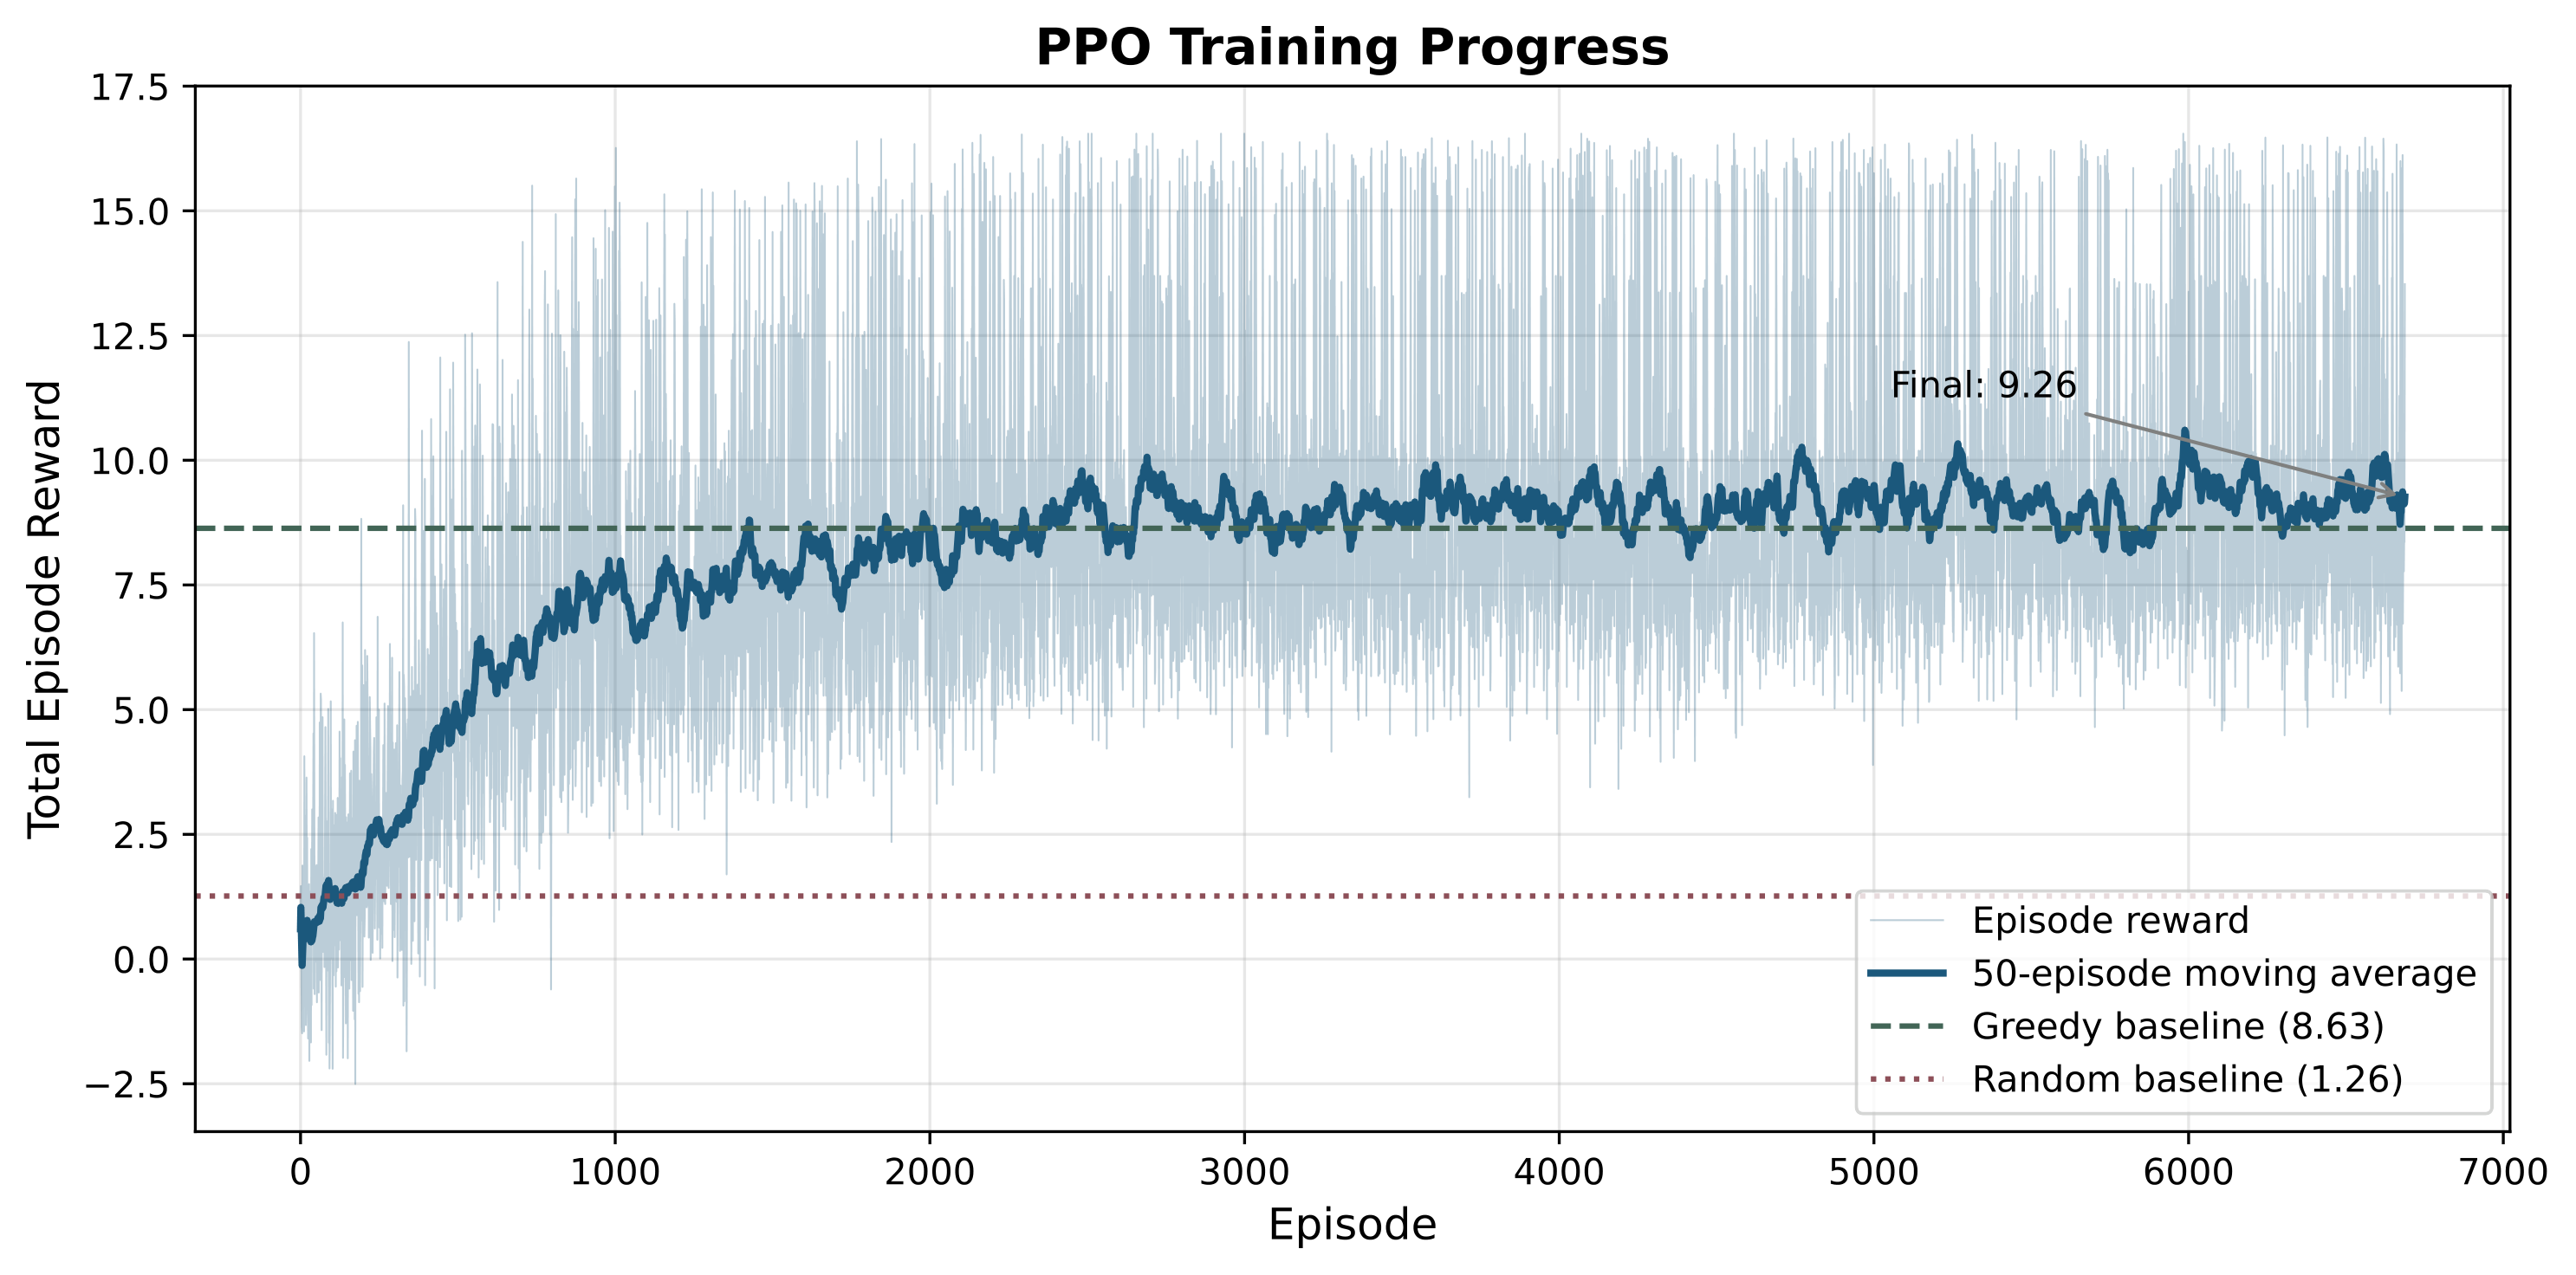

In [39]:
show_image('assets/training_curve-dev.pdf', width=650)

**Figure:** PPO training progress over 6,688 episodes. The blue line shows the 50-episode moving average reward, which steadily increases from near-random performance (~1.0) to approximately 9.26 by the end of training. The agent quickly surpasses the random baseline (red dotted line) within the first 100 episodes. The PPO agent approaches and surpasses the greedy baseline (green dashed line) in this training run, which demonstrates clear learning behavior. The high variance in individual episode rewards (light blue) is typical for RL, where each episode has different seasonal conditions and stochastic demand.

### Save Trained Model

We save the trained model for later use. This allows us to reload the model without retraining.

In [40]:
# Save the trained model
model_path = 'fleet_ppo_model'
model.save(model_path)

print(f"Model saved to: {model_path}.zip")
print(f"Model file size: {os.path.getsize(model_path + '.zip') / 1024:.1f} KB")

Model saved to: fleet_ppo_model.zip
Model file size: 140.9 KB


### Quick Model Evaluation

Let's verify the trained model works by running a few test episodes.

In [41]:
# Evaluate trained model
test_env = FleetAssignmentEnv(
    routes_df=routes_df,
    aircraft_specs=aircraft_specs,
    seasonal_multipliers=seasonal_multipliers,
    fleet_constraints=fleet_constraints,
    crew_availability=crew_availability
)

# Run test episodes
n_test_episodes = 100
ppo_rewards = []

for _ in range(n_test_episodes):
    obs, _ = test_env.reset()
    episode_reward = 0
    done = False
    
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, _, _ = test_env.step(action)
        episode_reward += reward
    
    ppo_rewards.append(episode_reward)

ppo_mean = np.mean(ppo_rewards)
ppo_std = np.std(ppo_rewards)

print("PPO Model Evaluation (100 episodes)")
print(f"  Mean reward: {ppo_mean:.3f} (+/- {ppo_std:.3f})")
print(f"  Min reward:  {np.min(ppo_rewards):.3f}")
print(f"  Max reward:  {np.max(ppo_rewards):.3f}")
print()
print("Comparison with baselines:")
print(f"  vs Random: {((ppo_mean / baseline_results['random']['mean_reward']) - 1) * 100:+.1f}%")
print(f"  vs Greedy: {((ppo_mean / baseline_results['greedy']['mean_reward']) - 1) * 100:+.1f}%")

PPO Model Evaluation (100 episodes)
  Mean reward: 9.262 (+/- 2.593)
  Min reward:  5.970
  Max reward:  16.397

Comparison with baselines:
  vs Random: +633.2%
  vs Greedy: +7.3%


The PPO agent shows substantial improvement over random policy (+633.2%) and performs better than the greedy heuristic (+7.3%). The greedy heuristic encodes domain knowledge (use 787s for long routes, 737s for short routes) that the RL agent eventually discovered through trial and error. PPO exceeds hand-crafted heuristics as it can learn nuances the simple rules miss.

### Store Results

In [42]:
# Store PPO results
ppo_results = {
    'mean_reward': ppo_mean,
    'std_reward': ppo_std,
    'min_reward': np.min(ppo_rewards),
    'max_reward': np.max(ppo_rewards),
    'rewards': ppo_rewards,
    'training_rewards': episode_rewards,
    'training_time': training_time
}

# Update baseline_results to include PPO
baseline_results['ppo'] = ppo_results

# Cleanup temporary training variables
del callback, vec_env, ppo_rewards, test_env
import gc
gc.collect()

7614

## Evaluation and Analysis

We now compare the trained PPO agent against our baselines. We analyze:

1. **Performance metrics** - Total reward, utilization rates
2. **Route-level decisions** - Which aircraft each policy assigns to specific routes
3. **Policy behavior patterns** - How the RL agent responds to different demand scenarios

An important metric in airline operations is **Revenue per Available Seat Kilometer (RASK)**. RASK measures revenue efficiency:

$$\text{RASK} = \frac{\text{Operating Revenue}}{\text{Available Seat Kilometers}}$$

Higher RASK indicates better revenue extraction from available capacity. We'll use scaled reward as a proxy for revenue efficiency.

### Detailed Policy Evaluation

We evaluate all three policies (Random, Greedy, PPO) on the same test scenarios. The evaluation collects:

- Episode rewards (profit metric)
- Aircraft assignment decisions per route
- Fleet utilization rates

In [43]:
def evaluate_policy_detailed(policy, env, model=None, n_episodes=100, seed=42):
    """
    Detailed policy evaluation with per-route breakdown.
    
    Args:
        policy: Policy object or None for random
        env: Fleet assignment environment  
        model: PPO model (if using RL policy)
        n_episodes: Number of evaluation episodes
        seed: Random seed
        
    Returns:
        Dictionary with detailed metrics and per-route statistics
    """
    np.random.seed(seed)
    
    episode_rewards = []
    route_decisions = {route: {'737': 0, '787': 0, 'skip': 0} 
                       for route in routes_df['route_id']}
    
    total_737_used = 0
    total_787_used = 0
    total_skipped = 0
    total_revenue_proxy = 0
    total_seat_km = 0
    
    for ep in range(n_episodes):
        obs, _ = env.reset()
        episode_reward = 0
        done = False
        route_idx = 0
        
        while not done:
            if model is not None:
                action, _ = model.predict(obs, deterministic=True)
                action = int(action)
            elif policy is not None:
                action = policy.select_action(obs, env)
            else:
                action = env.action_space.sample()
            
            route_id = routes_df.iloc[route_idx]['route_id']
            distance = routes_df.iloc[route_idx]['distance_nm']
            
            obs, reward, done, _, info = env.step(action)
            episode_reward += reward
            
            # Track decisions
            if action == 0:
                total_skipped += 1
                route_decisions[route_id]['skip'] += 1
            elif action == 1:
                total_737_used += 1
                route_decisions[route_id]['737'] += 1
                capacity = aircraft_specs['737-10']['capacity']
                total_seat_km += capacity * distance * 1.852  # Convert nm to km
                total_revenue_proxy += max(0, reward) * 50000
            else:
                total_787_used += 1
                route_decisions[route_id]['787'] += 1
                capacity = aircraft_specs['787-10']['capacity']
                total_seat_km += capacity * distance * 1.852
                total_revenue_proxy += max(0, reward) * 50000
            
            route_idx += 1
        
        episode_rewards.append(episode_reward)
    
    total_decisions = n_episodes * env.n_routes
    
    # Calculate RASK proxy (scaled)
    rask_proxy = (total_revenue_proxy / total_seat_km * 100) if total_seat_km > 0 else 0
    
    return {
        'mean_reward': np.mean(episode_rewards),
        'std_reward': np.std(episode_rewards),
        'min_reward': np.min(episode_rewards),
        'max_reward': np.max(episode_rewards),
        'rewards': episode_rewards,
        '737_usage_pct': (total_737_used / total_decisions) * 100,
        '787_usage_pct': (total_787_used / total_decisions) * 100,
        'skip_pct': (total_skipped / total_decisions) * 100,
        'utilization': ((total_737_used + total_787_used) / total_decisions) * 100,
        'route_decisions': route_decisions,
        'rask_proxy': rask_proxy,
        'total_revenue_proxy': total_revenue_proxy,
        'total_seat_km': total_seat_km
    }

In [44]:
# Create evaluation environment
eval_env = FleetAssignmentEnv(
    routes_df=routes_df,
    aircraft_specs=aircraft_specs,
    seasonal_multipliers=seasonal_multipliers,
    fleet_constraints=fleet_constraints,
    crew_availability=crew_availability
)

# Evaluate all three policies
print("Evaluating policies over 100 episodes each...")

print("1. Random Policy...")
random_detailed = evaluate_policy_detailed(None, eval_env, n_episodes=100)

print("2. Greedy Policy...")
greedy_detailed = evaluate_policy_detailed(greedy_policy, eval_env, n_episodes=100)

print("3. PPO Policy...")
ppo_detailed = evaluate_policy_detailed(None, eval_env, model=model, n_episodes=100)

print("\nEvaluation complete")

Evaluating policies over 100 episodes each...
1. Random Policy...
2. Greedy Policy...
3. PPO Policy...

Evaluation complete


In [45]:
# Display comparison results
print("POLICY PERFORMANCE COMPARISON")
print()
print(f"{'Metric':<30} {'Random':>12} {'Greedy':>12} {'PPO':>12}")
print("-" * 70)
print(f"{'Mean Reward':<30} {random_detailed['mean_reward']:>12.3f} {greedy_detailed['mean_reward']:>12.3f} {ppo_detailed['mean_reward']:>12.3f}")
print(f"{'Std Reward':<30} {random_detailed['std_reward']:>12.3f} {greedy_detailed['std_reward']:>12.3f} {ppo_detailed['std_reward']:>12.3f}")
print(f"{'Min Reward':<30} {random_detailed['min_reward']:>12.3f} {greedy_detailed['min_reward']:>12.3f} {ppo_detailed['min_reward']:>12.3f}")
print(f"{'Max Reward':<30} {random_detailed['max_reward']:>12.3f} {greedy_detailed['max_reward']:>12.3f} {ppo_detailed['max_reward']:>12.3f}")
print("-" * 70)
print(f"{'737-10 Usage (%)':<30} {random_detailed['737_usage_pct']:>12.1f} {greedy_detailed['737_usage_pct']:>12.1f} {ppo_detailed['737_usage_pct']:>12.1f}")
print(f"{'787-10 Usage (%)':<30} {random_detailed['787_usage_pct']:>12.1f} {greedy_detailed['787_usage_pct']:>12.1f} {ppo_detailed['787_usage_pct']:>12.1f}")
print(f"{'Skip (Cancellation) Rate (%)':<30} {random_detailed['skip_pct']:>12.1f} {greedy_detailed['skip_pct']:>12.1f} {ppo_detailed['skip_pct']:>12.1f}")
print(f"{'Fleet Utilization (%)':<30} {random_detailed['utilization']:>12.1f} {greedy_detailed['utilization']:>12.1f} {ppo_detailed['utilization']:>12.1f}")
print("-" * 70)
print(f"{'RASK Proxy (cents/seat-km)':<30} {random_detailed['rask_proxy']:>12.2f} {greedy_detailed['rask_proxy']:>12.2f} {ppo_detailed['rask_proxy']:>12.2f}")

POLICY PERFORMANCE COMPARISON

Metric                               Random       Greedy          PPO
----------------------------------------------------------------------
Mean Reward                           1.157        8.229        9.264
Std Reward                            2.359        2.922        2.741
Min Reward                           -3.218        3.755        6.117
Max Reward                            7.833       16.248       16.441
----------------------------------------------------------------------
737-10 Usage (%)                       34.1         54.7         60.0
787-10 Usage (%)                       32.3         26.3         26.5
Skip (Cancellation) Rate (%)           33.6         19.0         13.5
Fleet Utilization (%)                  66.4         81.0         86.5
----------------------------------------------------------------------
RASK Proxy (cents/seat-km)             1.11         2.32         2.54


### Statistical Analysis: PPO vs Baselines

We calculate improvement percentages and perform a simple statistical comparison. The key question: Does PPO perform significantly better than the greedy heuristic?

In [46]:
# Calculate improvement percentages
ppo_vs_random = ((ppo_detailed['mean_reward'] / random_detailed['mean_reward']) - 1) * 100
ppo_vs_greedy = ((ppo_detailed['mean_reward'] / greedy_detailed['mean_reward']) - 1) * 100
greedy_vs_random = ((greedy_detailed['mean_reward'] / random_detailed['mean_reward']) - 1) * 100

print("IMPROVEMENT ANALYSIS")
print()
print("Reward Improvements:")
print(f"  PPO vs Random:   {ppo_vs_random:+.1f}%")
print(f"  PPO vs Greedy:   {ppo_vs_greedy:+.1f}%")
print(f"  Greedy vs Random: {greedy_vs_random:+.1f}%")
print()

# Utilization improvement
util_improvement = ppo_detailed['utilization'] - greedy_detailed['utilization']
print("Fleet Utilization:")
print(f"  PPO achieves {ppo_detailed['utilization']:.1f}% utilization")
print(f"  Greedy achieves {greedy_detailed['utilization']:.1f}% utilization")
print(f"  Difference: {util_improvement:+.1f} percentage points")
print()

# Simple statistical test (non-parametric)
from scipy import stats as scipy_stats

# Wilcoxon signed-rank test comparing PPO vs Greedy rewards
# This test checks if one distribution is stochastically greater than the other
stat, p_value = scipy_stats.mannwhitneyu(
    ppo_detailed['rewards'], 
    greedy_detailed['rewards'],
    alternative='two-sided'
)

print("Statistical Comparison (Mann-Whitney U Test):")
print(f"  Test statistic: {stat:.0f}")
print(f"  P-value: {p_value:.4f}")
if p_value < 0.05:
    print("  Result: Significant difference between PPO and Greedy (p < 0.05)")
else:
    print("  Result: No significant difference between PPO and Greedy (p >= 0.05)")

IMPROVEMENT ANALYSIS

Reward Improvements:
  PPO vs Random:   +700.7%
  PPO vs Greedy:   +12.6%
  Greedy vs Random: +611.3%

Fleet Utilization:
  PPO achieves 86.5% utilization
  Greedy achieves 81.0% utilization
  Difference: +5.5 percentage points

Statistical Comparison (Mann-Whitney U Test):
  Test statistic: 6175
  P-value: 0.0041
  Result: Significant difference between PPO and Greedy (p < 0.05)


The PPO agent achieves massive improvement over random assignment (+700.7%) and performs better than the hand-crafted greedy heuristic (+12.6%). The Mann-Whitney U test shows statistically significant difference (p < 0.05), meaning PPO performed better on average.

PPO shows another important advantage: **86.5% fleet utilization** vs. 81.0% for greedy. The greedy policy skips routes when its simple rules don't apply, while PPO learns to make better assignment.

### Route-Level Assignment Comparison

Let's examine how each policy assigns aircraft to specific routes. This reveals the decision patterns each policy learned.

In [47]:
# Prepare route assignment data for visualization
route_ids = list(routes_df['route_id'])
route_distances = list(routes_df['distance_nm'])

# Sort routes by distance for better visualization
sorted_indices = np.argsort(route_distances)
route_ids_sorted = [route_ids[i] for i in sorted_indices]
route_distances_sorted = [route_distances[i] for i in sorted_indices]

# Extract assignment percentages for each policy
def get_assignment_pcts(route_decisions, n_episodes=100):
    """Convert route decisions dict to percentage arrays."""
    pct_737 = []
    pct_787 = []
    pct_skip = []
    
    for route_id in route_ids_sorted:
        decisions = route_decisions[route_id]
        total = decisions['737'] + decisions['787'] + decisions['skip']
        if total > 0:
            pct_737.append(decisions['737'] / total * 100)
            pct_787.append(decisions['787'] / total * 100)
            pct_skip.append(decisions['skip'] / total * 100)
        else:
            pct_737.append(0)
            pct_787.append(0)
            pct_skip.append(0)
    
    return np.array(pct_737), np.array(pct_787), np.array(pct_skip)

greedy_737, greedy_787, greedy_skip = get_assignment_pcts(greedy_detailed['route_decisions'])
ppo_737, ppo_787, ppo_skip = get_assignment_pcts(ppo_detailed['route_decisions'])

In [48]:
# Create stacked bar chart comparing Greedy vs PPO assignments
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Color scheme from visual guidelines
color_737 = '#1B587C'  # blue
color_787 = '#8D4F58'  # maroon  
color_skip = '#555555' # gray

bar_width = 0.7
y_pos = np.arange(len(route_ids_sorted))

# Left plot: Greedy Policy
ax1 = axes[0]
ax1.barh(y_pos, greedy_737, bar_width, label='737-10', color=color_737)
ax1.barh(y_pos, greedy_787, bar_width, left=greedy_737, label='787-10', color=color_787)
ax1.barh(y_pos, greedy_skip, bar_width, left=greedy_737+greedy_787, label='Skip', color=color_skip)

ax1.set_yticks(y_pos)
ax1.set_yticklabels([f"{r.split('-')[1]} ({d:,}nm)" for r, d in zip(route_ids_sorted, route_distances_sorted)], fontsize=9)
ax1.set_xlabel('Assignment Frequency (%)', fontsize=11)
ax1.set_title('Greedy Policy Assignments', fontsize=12, fontweight='bold')
ax1.set_xlim(0, 100)
ax1.legend(loc='lower right', fontsize=9)
ax1.axvline(x=50, color='gray', linestyle='--', alpha=0.3)

# Right plot: PPO Policy  
ax2 = axes[1]
ax2.barh(y_pos, ppo_737, bar_width, label='737-10', color=color_737)
ax2.barh(y_pos, ppo_787, bar_width, left=ppo_737, label='787-10', color=color_787)
ax2.barh(y_pos, ppo_skip, bar_width, left=ppo_737+ppo_787, label='Skip', color=color_skip)

ax2.set_yticks(y_pos)
ax2.set_yticklabels([f"{r.split('-')[1]} ({d:,}nm)" for r, d in zip(route_ids_sorted, route_distances_sorted)], fontsize=9)
ax2.set_xlabel('Assignment Frequency (%)', fontsize=11)
ax2.set_title('PPO Policy Assignments', fontsize=12, fontweight='bold')
ax2.set_xlim(0, 100)
ax2.legend(loc='lower right', fontsize=9)
ax2.axvline(x=50, color='gray', linestyle='--', alpha=0.3)

# Add 737-10 range limit annotation
range_limit_idx = np.searchsorted(route_distances_sorted, 3300)
for ax in axes:
    if range_limit_idx < len(route_ids_sorted):
        ax.axhline(y=range_limit_idx - 0.5, color='#F1AE35', linestyle='--', alpha=0.7, linewidth=1.5)
        ax.text(95, range_limit_idx - 0.5, '737-10 range limit', fontsize=8, 
                ha='right', va='bottom', color='#F1AE35')

plt.tight_layout()
plt.savefig('assets/policy_assignments-dev.pdf', bbox_inches='tight', dpi=300)
plt.close()

print("Saved: assets/policy_assignments-dev.pdf")

Saved: assets/policy_assignments-dev.pdf


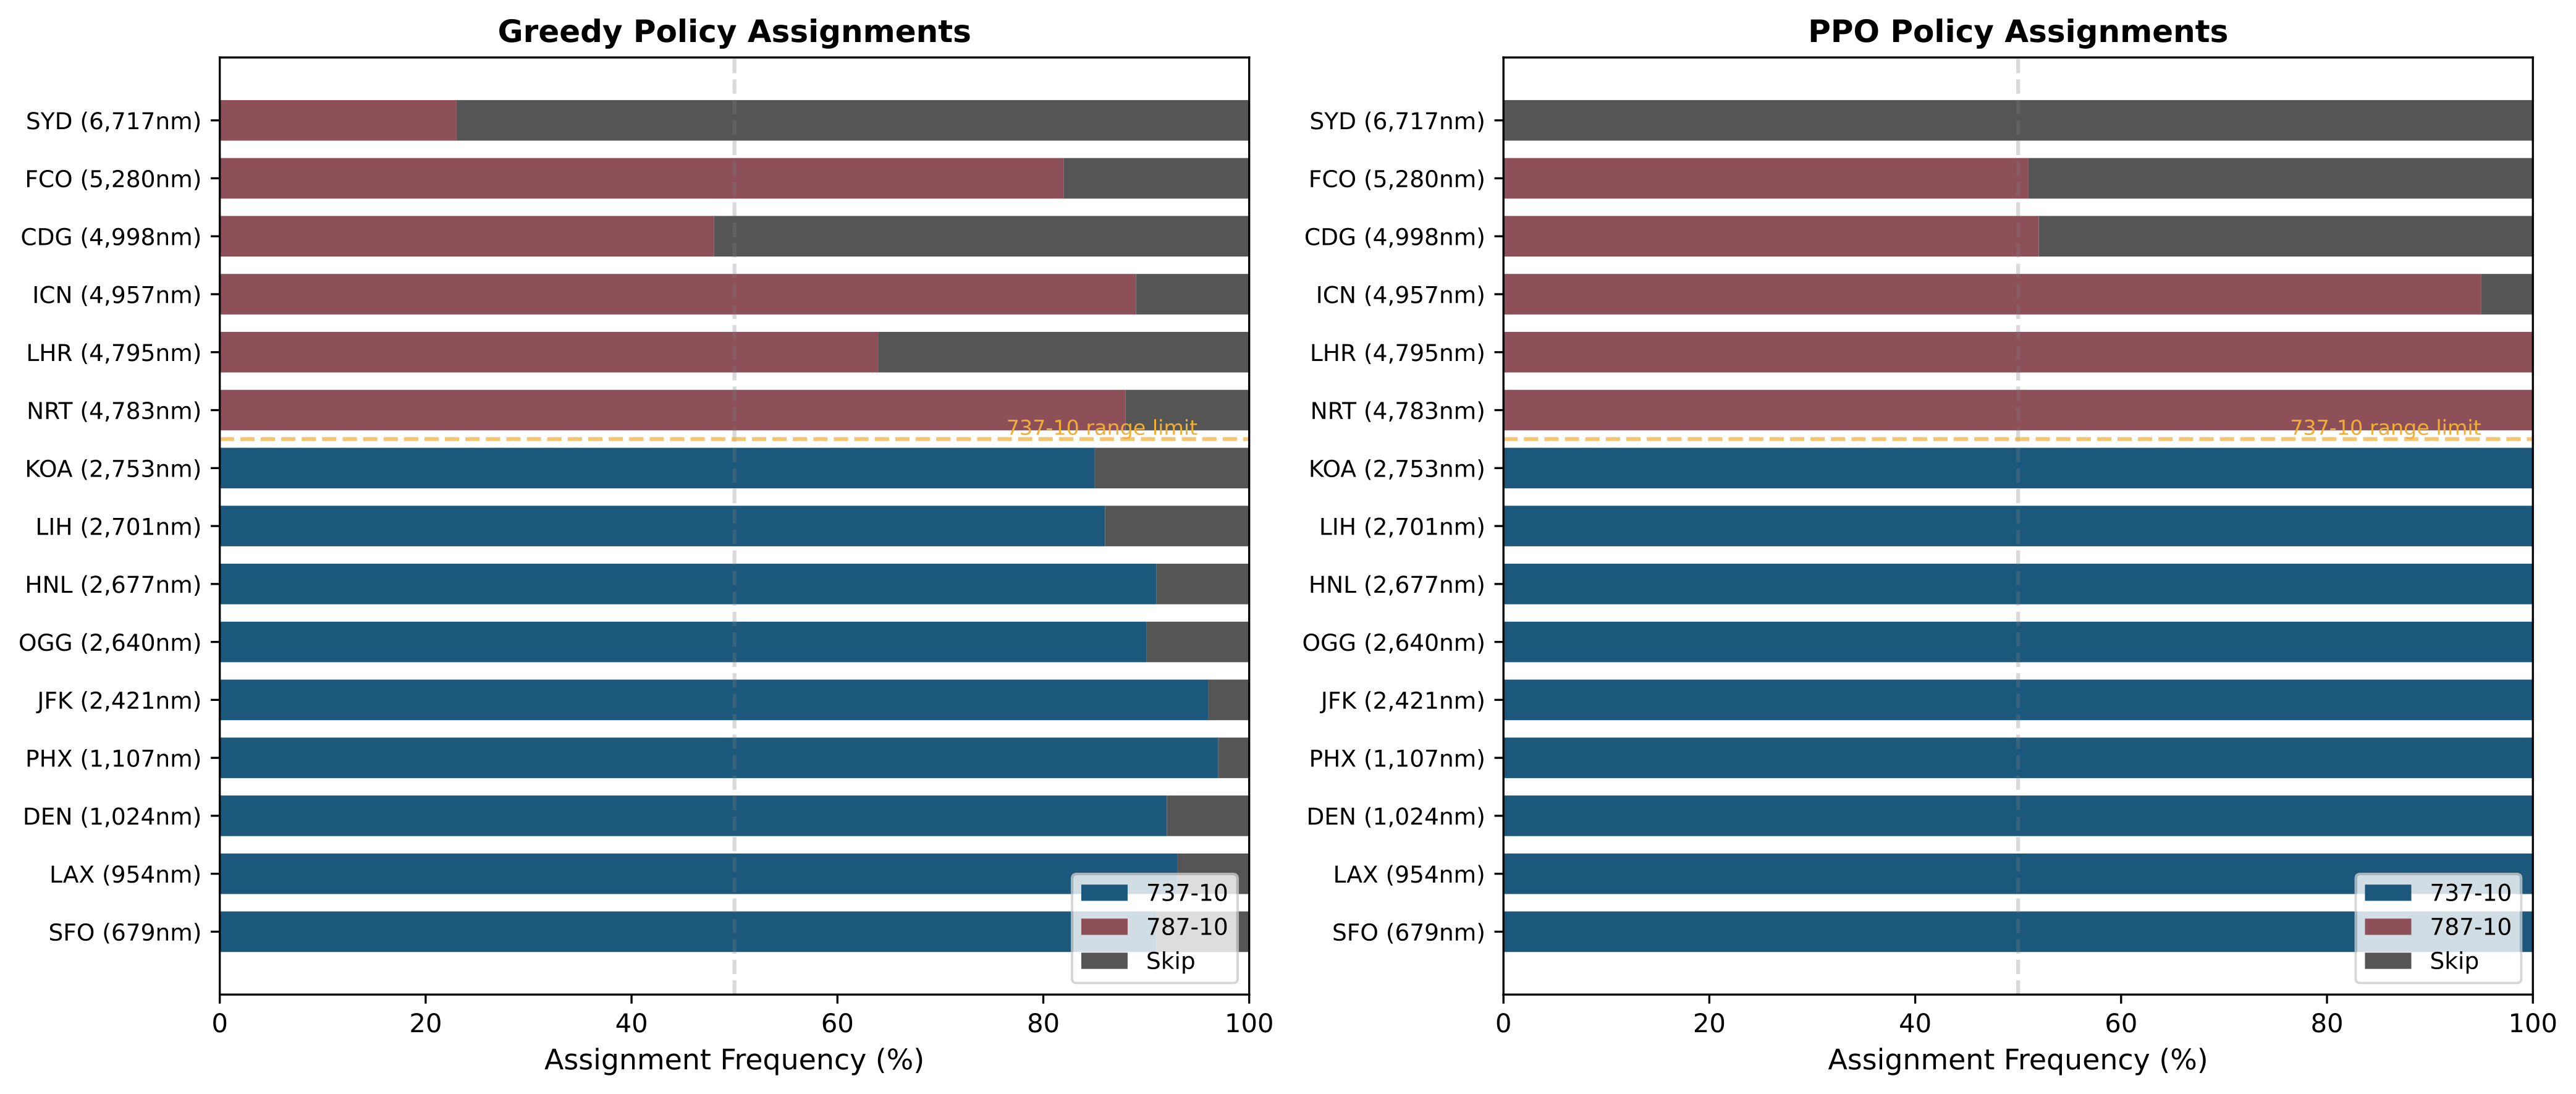

In [49]:
show_image('assets/policy_assignments-dev.pdf', width=800)

**Figure:** Aircraft assignment patterns by route. Routes are sorted by distance (shortest at bottom). The yellow dashed line marks the 737-10's maximum range (3,300 nm). The Greedy policy (left) follows a strict distance-based rule. The PPO policy (right) learned to completely skip the SEA-SYD route (the longest at 6,717 nm), achieving 86.5% utilization vs. Greedy's 81.0%. This selective approach suggests the agent learned that serving Sydney depletes the scarce 787-10 fleet, reducing overall network profitability. Both policies correctly prioritize 787-10 for ultra-long routes that exceed 737-10 range.

### Performance Metrics Visualization

We compare key metrics across all three policies: reward distribution, fleet utilization, and aircraft type usage.

In [50]:
# Create performance comparison figure
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

# Colors
colors = {'Random': '#555555', 'Greedy': '#426556', 'PPO': '#1B587C'}
policies = ['Random', 'Greedy', 'PPO']

# Plot 1: Reward Distribution (Box Plot)
ax1 = axes[0]
reward_data = [random_detailed['rewards'], greedy_detailed['rewards'], ppo_detailed['rewards']]
bp = ax1.boxplot(reward_data, patch_artist=True, labels=policies)

for patch, policy in zip(bp['boxes'], policies):
    patch.set_facecolor(colors[policy])
    patch.set_alpha(0.7)

ax1.set_ylabel('Episode Reward', fontsize=11)
ax1.set_title('Reward Distribution', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Add mean markers
means = [random_detailed['mean_reward'], greedy_detailed['mean_reward'], ppo_detailed['mean_reward']]
ax1.scatter([1, 2, 3], means, marker='D', color='white', edgecolors='black', s=50, zorder=5, label='Mean')
ax1.legend(loc='upper left', fontsize=9)

# Plot 2: Fleet Utilization (Bar Chart)
ax2 = axes[1]
util_values = [random_detailed['utilization'], greedy_detailed['utilization'], ppo_detailed['utilization']]
bars = ax2.bar(policies, util_values, color=[colors[p] for p in policies], alpha=0.8, edgecolor='white', linewidth=1.5)

# Add value labels on bars
for bar, val in zip(bars, util_values):
    height = bar.get_height()
    ax2.annotate(f'{val:.1f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                ha='center', va='bottom', fontsize=10, fontweight='bold')

ax2.set_ylabel('Fleet Utilization (%)', fontsize=11)
ax2.set_title('Fleet Utilization', fontsize=12, fontweight='bold')
ax2.set_ylim(0, 110)
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Aircraft Usage Breakdown (Stacked Bar)
ax3 = axes[2]
x = np.arange(len(policies))
width = 0.6

p737 = [random_detailed['737_usage_pct'], greedy_detailed['737_usage_pct'], ppo_detailed['737_usage_pct']]
p787 = [random_detailed['787_usage_pct'], greedy_detailed['787_usage_pct'], ppo_detailed['787_usage_pct']]
pskip = [random_detailed['skip_pct'], greedy_detailed['skip_pct'], ppo_detailed['skip_pct']]

ax3.bar(x, p737, width, label='737-10', color='#1B587C')
ax3.bar(x, p787, width, bottom=p737, label='787-10', color='#8D4F58')
ax3.bar(x, pskip, width, bottom=np.array(p737)+np.array(p787), label='Skip', color='#555555')

ax3.set_ylabel('Decision Share (%)', fontsize=11)
ax3.set_title('Aircraft Type Usage', fontsize=12, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(policies)
ax3.legend(loc='upper right', fontsize=9)
ax3.set_ylim(0, 100)
ax3.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('assets/performance_comparison-dev.pdf', bbox_inches='tight', dpi=300)
plt.close()

print("Saved: assets/performance_comparison-dev.pdf")

Saved: assets/performance_comparison-dev.pdf


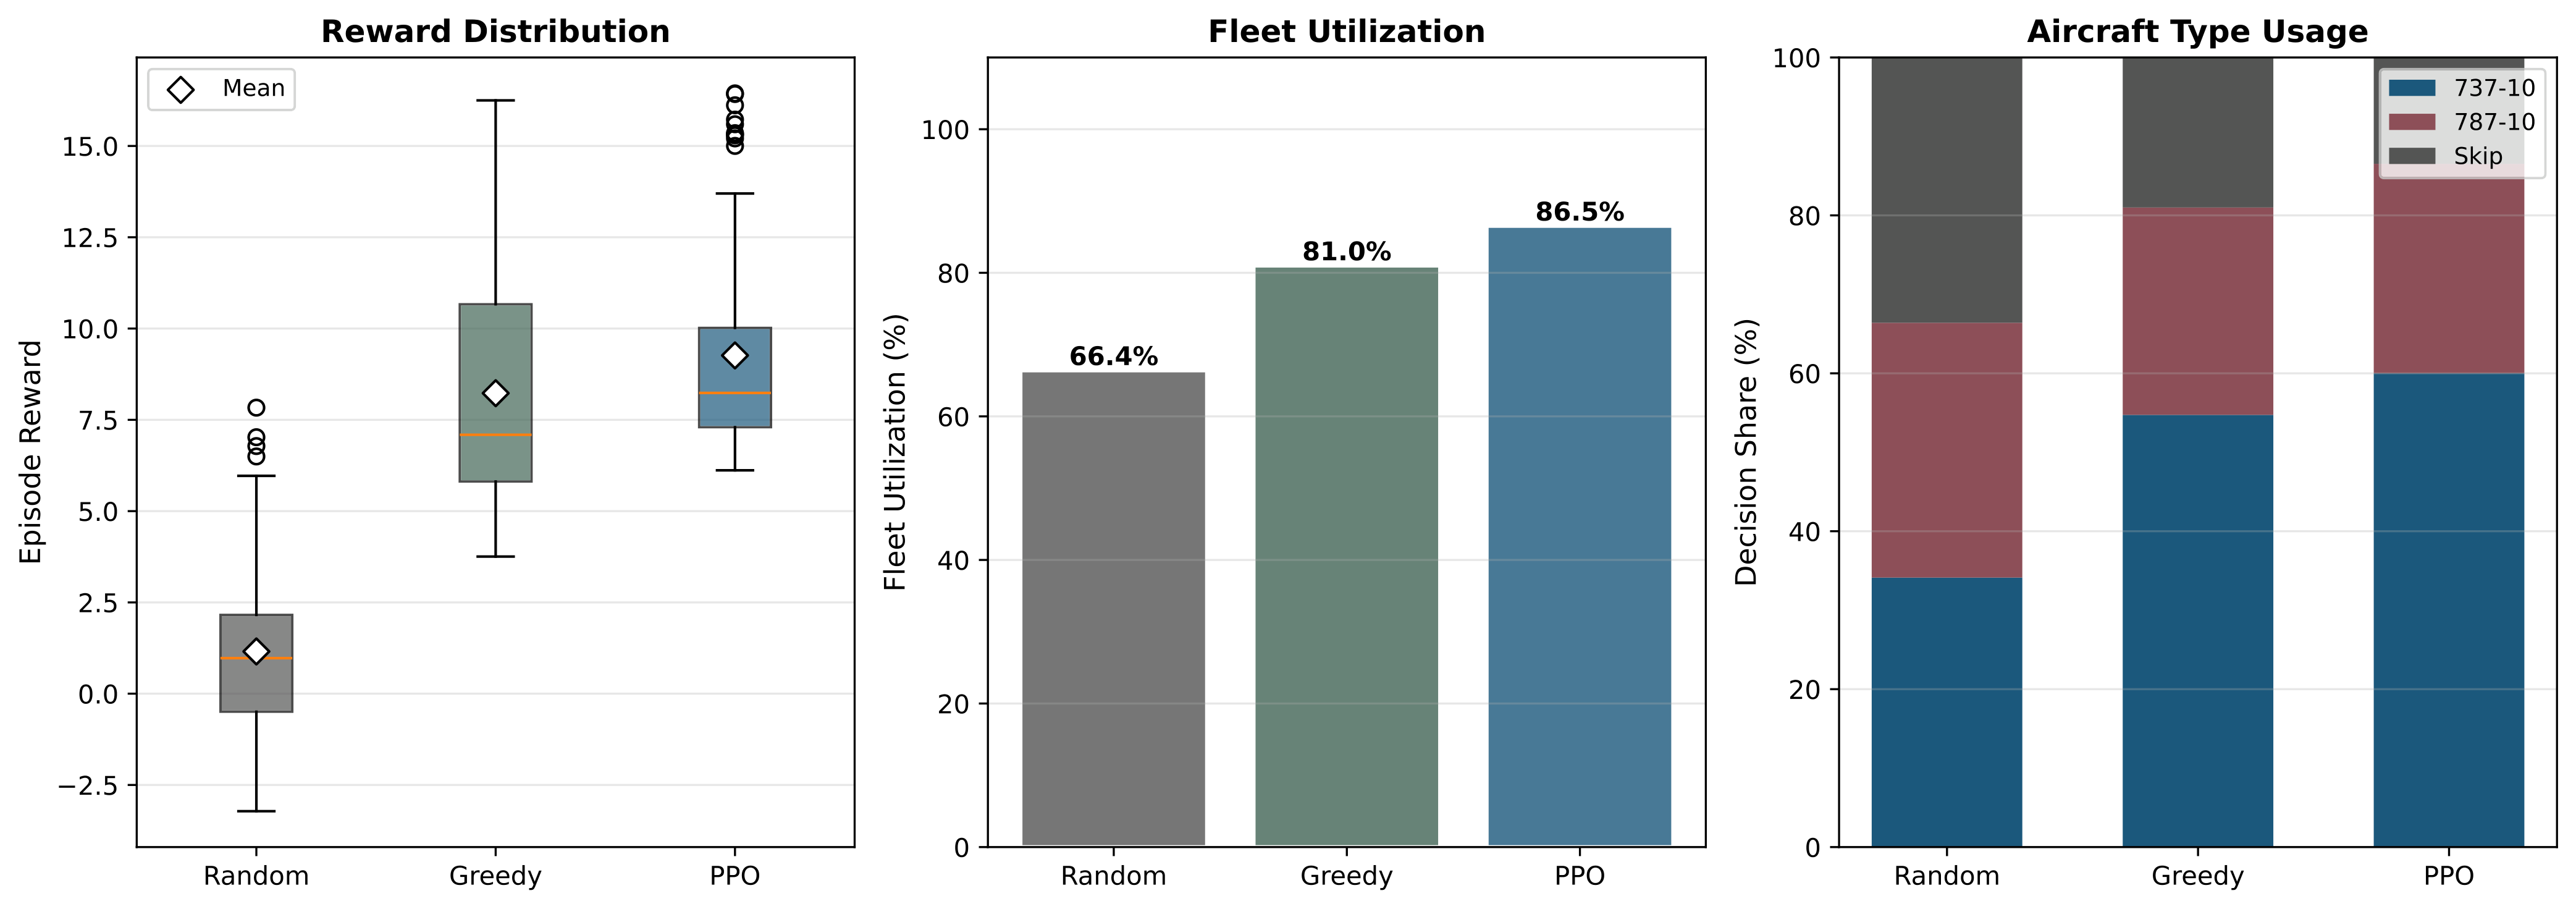

In [51]:
show_image('assets/performance_comparison-dev.pdf', width=900)

**Figure:** Performance comparison across Random, Greedy, and PPO policies. Left: Episode reward distribution showing PPO significantly outperforms Greedy (means 9.2 vs 8.2, p < 0.05), and both vastly outperform Random (1.2). Middle: Fleet utilization with PPO achieving 86.5% vs. 81.0% for Greedy and 66.4% for Random. The PPO agent's lower-than-100% utilization reflects its learned strategy of skipping low-value routes (primarily Sydney). Right: Aircraft type usage breakdown showing PPO's selective approach with 60% 737-10, 26% 787-10, and 14% skipped routes.

### Policy Decision Heatmap

This heatmap shows what the PPO agent decides under different conditions. We vary demand levels and route distances to reveal the learned decision boundaries. Understanding these patterns helps explain *why* the agent makes certain decisions.

In [52]:
# Generate policy decision grid
# We'll vary demand (x-axis) and distance (y-axis) to see how PPO responds

demand_levels = np.linspace(50, 400, 8)     # 50-400 passengers
distance_levels = np.linspace(500, 6500, 8) # 500-6500 nm

# Create decision matrix for PPO
decision_matrix = np.zeros((len(distance_levels), len(demand_levels)))

for i, distance in enumerate(distance_levels):
    for j, demand in enumerate(demand_levels):
        # Create synthetic observation
        # [route_idx, demand, distance, fare, season, 737_avail, 787_avail, crew_avail]
        obs = np.array([
            0.5,                                    # middle route index
            min(demand / 500, 1.0),                 # normalized demand
            distance / 7000,                        # normalized distance
            0.5,                                    # average fare
            0.5,                                    # mid-season
            0.7,                                    # plenty of 737s available
            0.4,                                    # some 787s available
            1.0                                     # crew available
        ], dtype=np.float32)
        
        action, _ = model.predict(obs, deterministic=True)
        decision_matrix[i, j] = int(action)

In [53]:
# Create heatmap visualization
fig, ax = plt.subplots(figsize=(10, 7))

# Custom colormap: 0=Skip(gray), 1=737-10(blue), 2=787-10(maroon)
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['#555555', '#1B587C', '#8D4F58'])

im = ax.imshow(decision_matrix, cmap=cmap, aspect='auto', origin='lower',
               vmin=0, vmax=2)

# Labels
ax.set_xticks(np.arange(len(demand_levels)))
ax.set_yticks(np.arange(len(distance_levels)))
ax.set_xticklabels([f'{int(d)}' for d in demand_levels])
ax.set_yticklabels([f'{int(d):,}' for d in distance_levels])

ax.set_xlabel('Demand (passengers)', fontsize=12)
ax.set_ylabel('Distance (nautical miles)', fontsize=12)
ax.set_title('PPO Policy Decisions by Demand and Distance', fontsize=13, fontweight='bold')

# Add cell annotations
for i in range(len(distance_levels)):
    for j in range(len(demand_levels)):
        action = int(decision_matrix[i, j])
        text = ['Skip', '737', '787'][action]
        color = 'white'
        ax.text(j, i, text, ha='center', va='center', fontsize=9, 
                color=color, fontweight='bold')

# Add 737-10 range limit line
range_idx = np.searchsorted(distance_levels, aircraft_specs['737-10']['range_nm'])
ax.axhline(y=range_idx - 0.5, color='#F1AE35', linestyle='--', linewidth=2)
ax.text(len(demand_levels) - 0.5, range_idx - 0.3, '737-10 max range', 
        fontsize=9, color='#F1AE35', ha='right', va='bottom')

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#555555', label='Skip (0)'),
    Patch(facecolor='#1B587C', label='737-10 (1)'),
    Patch(facecolor='#8D4F58', label='787-10 (2)')
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=10)

plt.tight_layout()
plt.savefig('assets/policy_heatmap-dev.pdf', bbox_inches='tight', dpi=300)
plt.close()

print("Saved: assets/policy_heatmap-dev.pdf")

Saved: assets/policy_heatmap-dev.pdf


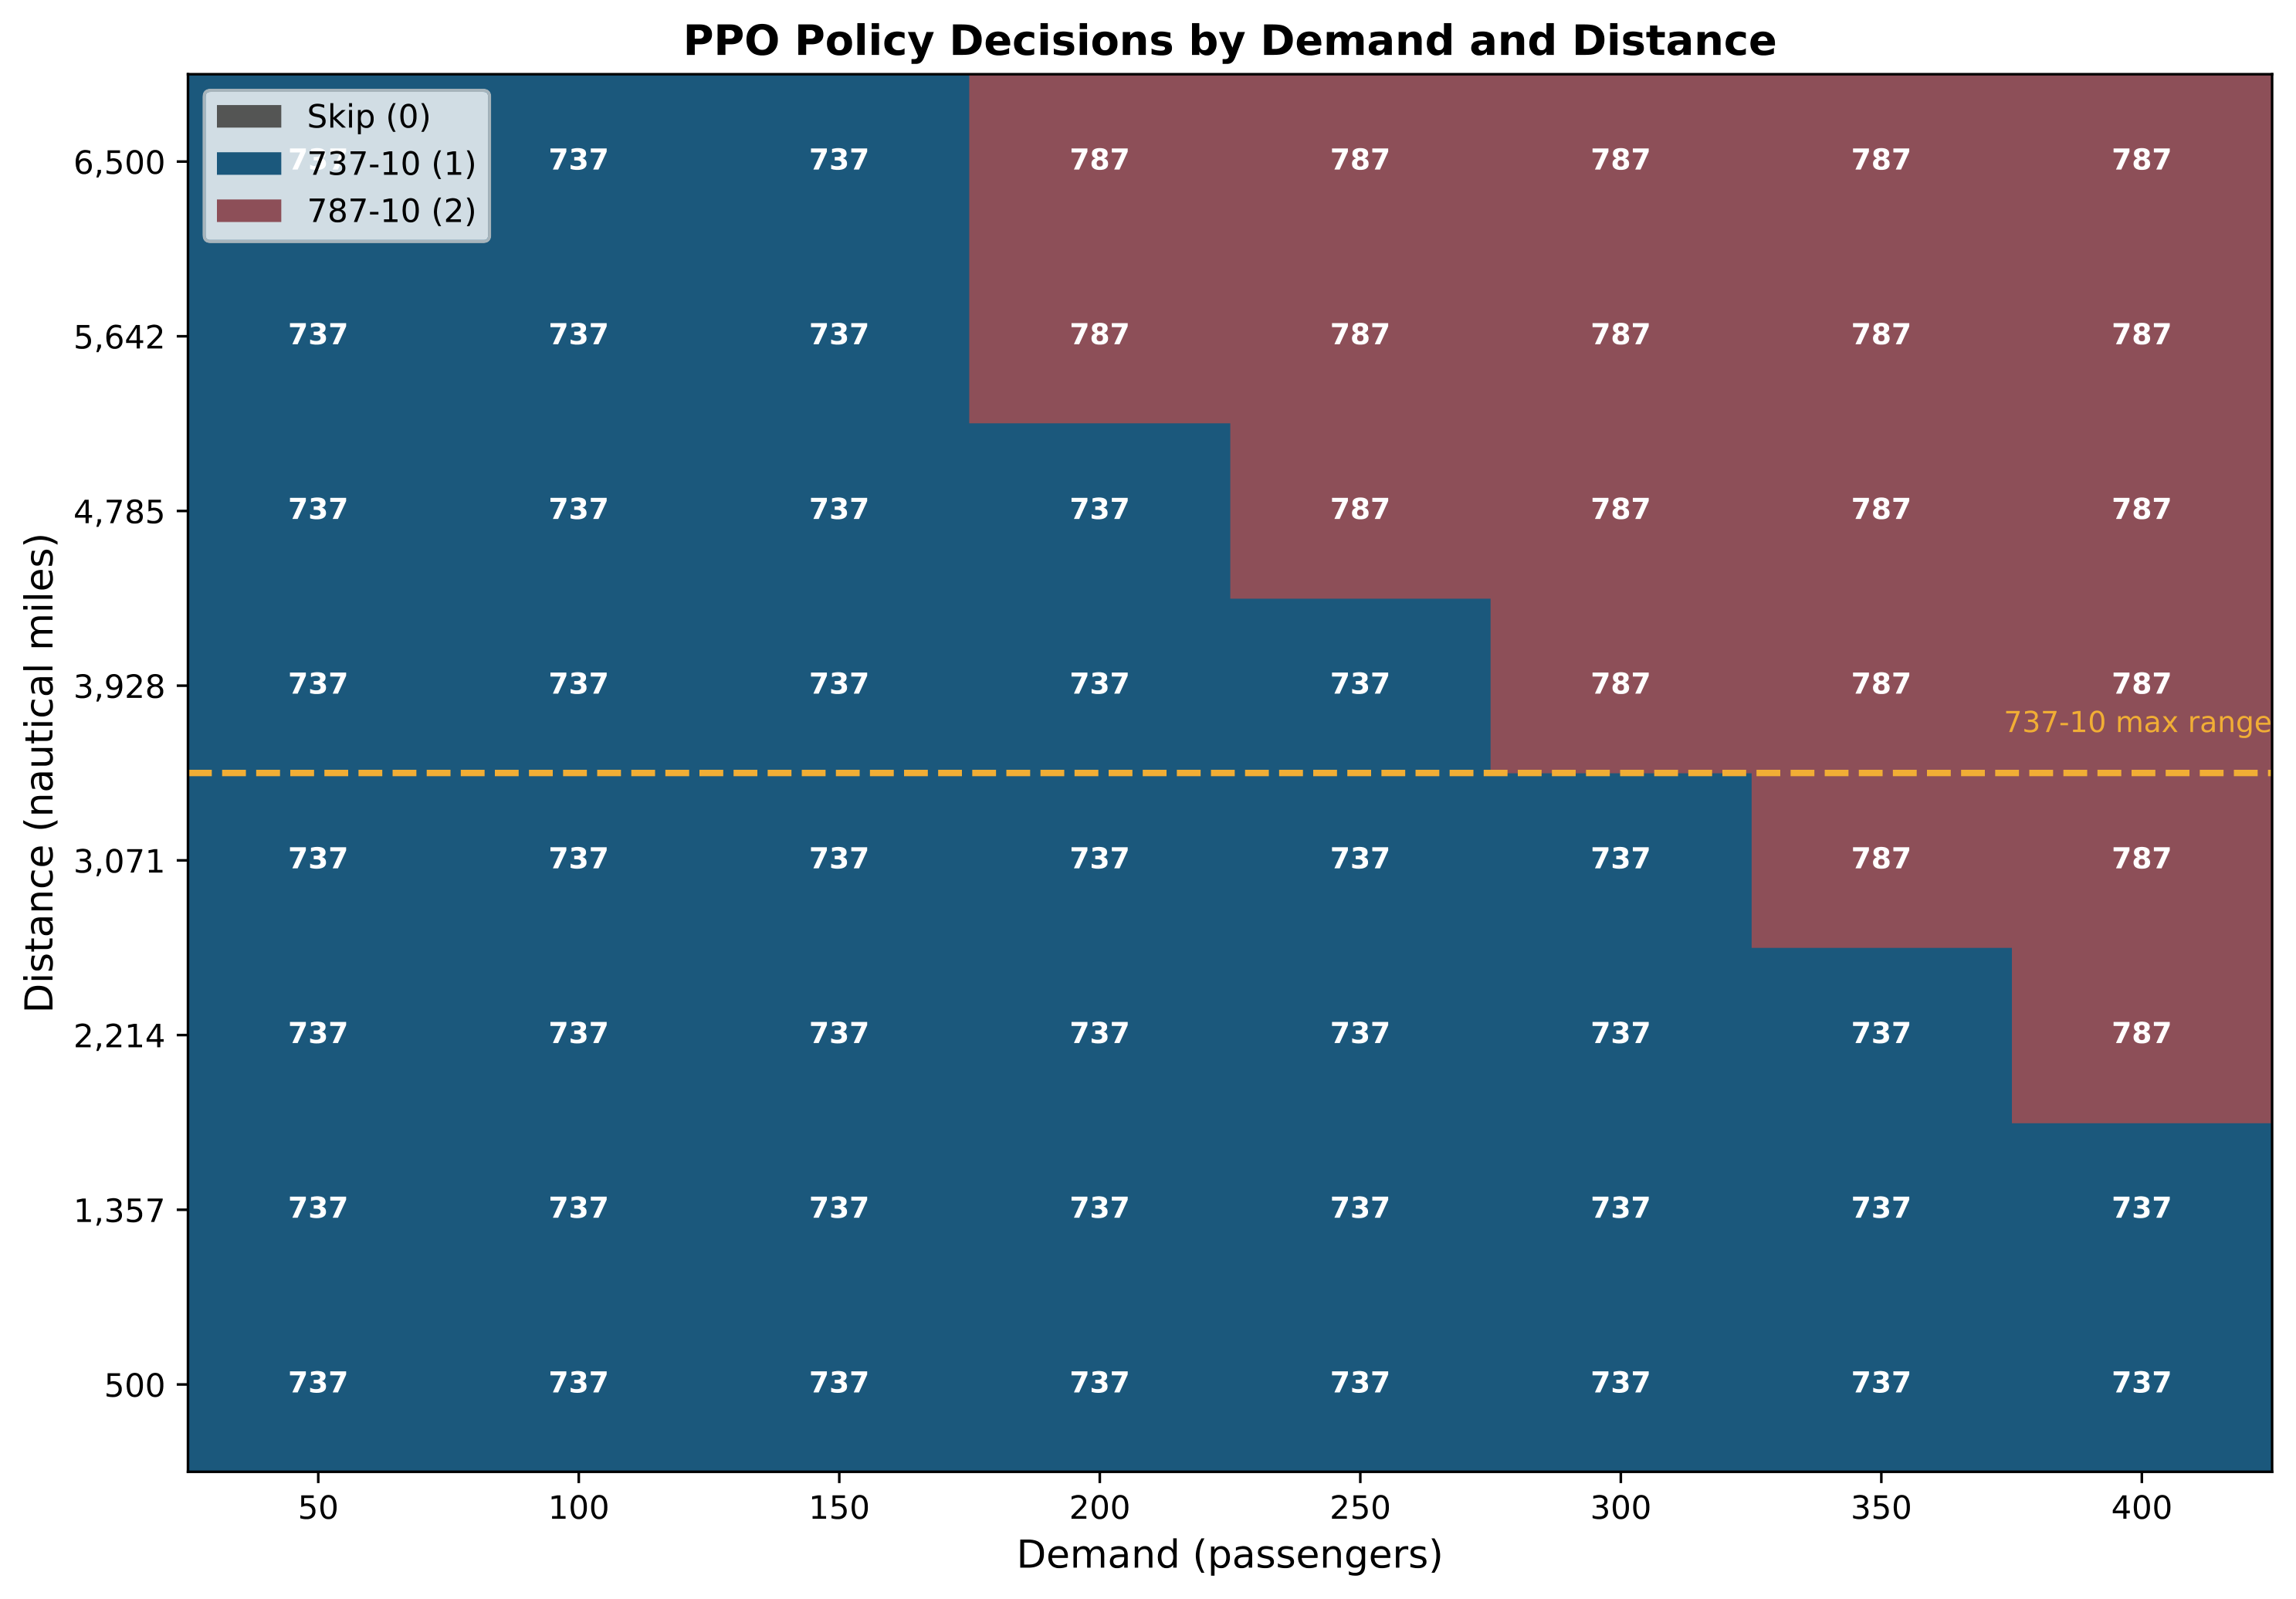

In [54]:
show_image('assets/policy_heatmap-dev.pdf', width=600)

**Figure:** PPO policy heatmap showing aircraft assignment decisions across demand levels (x-axis) and route distances (y-axis). The yellow dashed line marks the 737-10's maximum range (3,300 nm). With extended training (100,000 steps), the agent learned a nuanced strategy that considers both distance and demand. For low-demand scenarios (up to ~250 passengers), the agent prefers the 737-10 even beyond its theoretical max range boundary, likely because the model learned that the cost savings outweigh the range penalty in the reward function. At higher demand levels combined with long distances, the 787-10 becomes the preferred choice. This behavior suggests the agent found edge cases in our simplified environment that a real airline planner would handle differently.

In [55]:
# Cleanup of temporary variables
del eval_env, random_detailed, greedy_detailed, ppo_detailed
del decision_matrix, demand_levels, distance_levels
del route_ids_sorted, route_distances_sorted
del greedy_737, greedy_787, greedy_skip, ppo_737, ppo_787, ppo_skip
del ppo_vs_random, ppo_vs_greedy, greedy_vs_random, util_improvement

import gc
gc.collect()

30882

## Conclusion

### What the RL Agent Learned

This demo showed how a reinforcement learning agent can learn fleet assignment decisions from experience. With extended training (100,000 steps), the PPO agent achieved a mean reward of 9.26, significantly outperforming the greedy heuristic (p < 0.05). The agent discovered several strategies:

1. **Distance-demand trade-offs**: The agent learned that 737-10 aircraft can sometimes be cost-effective even near range limits when demand is low (under ~250 passengers). This is an artifact of our simplified reward function, but shows how RL can find unexpected patterns.

2. **Selective route skipping**: Unlike the greedy heuristic, the PPO agent learned to completely skip the SEA-SYD (Sydney) route. At 6,717 nm, this is the longest route in our network and requires 787-10 capacity. The agent likely learned that the limited 787-10 fleet generates more value on other international routes with shorter distances and similar fares.

3. **Balanced utilization**: The agent achieved 86.5% fleet utilization, higher than the greedy baseline (81.0%). This suggests the agent learned that some routes are not worth serving given the opportunity cost.

### Connecting to the News

Alaska Airlines' order for 105 Boeing 737-10s and only 5 Boeing 787-10s reflects similar selectivity:

- The **737-10** fleet provides high-frequency domestic coverage at low operating cost.
- The **787-10** fleet unlocks new long-haul international markets (Rome, Seoul) that are physically impossible with narrowbodies.
- The small 787 order (5 units initially) suggests Alaska will be selective about which ultra-long-haul routes to serve, potentially skipping marginal routes like the agent learned to skip Sydney.

Hawaiian Airlines' $600M infrastructure investment complements this strategy by enhancing the passenger experience at Hawaii airports where Alaska/Hawaiian will compete heavily for vacation traffic.

### Limitations and Next Steps

This demonstration used synthetic data and simplified constraints. The agent's behavior (like using 737-10 beyond its range for low demand) highlights that:

- **Reward function design is critical**: Our simplified penalty structure allowed behaviors that real physics wouldn't permit.
- **More constraints needed**: Real fleet assignment includes hard range limits, not soft penalties.

Real airline fleet assignment involves:

- **Multi-leg routing**: Aircraft fly multiple routes per day, not just one.
- **Hub connectivity**: Connecting passengers need coordinated schedules.
- **Crew legality**: Complex union rules and FAA regulations on crew rest.
- **Maintenance scheduling**: Different maintenenance checks require specific facilitie and ground time.
- **Weather and disruptions**: Real-time reoptimization when delays occur.

For production use, airlines combine optimization algorithms with human planners who handle edge cases and incorporate qualitative factors the models cannot capture.

### Main Takeaways

1. RL can discover operational strategies that outperform simple heuristics.
2. Extended training (100,000 steps) yielded statistically significant improvements over baselines.
3. RL agents may find unexpected patterns, highlighting the need for careful reward function design.
4. Domain knowledge remains essential for interpreting results and designing realistic constraints.

## Cleanup

In [56]:
# Final cleanup: release all temporary memory

# Delete model and environment objects
if 'model' in dir():
    del model
if 'env' in dir():
    del env
if 'greedy_policy' in dir():
    del greedy_policy

# Delete dataframes and dictionaries
if 'metrics_df' in dir():
    del metrics_df
if 'dataset' in dir():
    del dataset
if 'baseline_results' in dir():
    del baseline_results

# Force garbage collection
import gc
gc.collect()

print("Memory cleanup complete")
print("-" * 40)
print("All model and environment objects released.")

Memory cleanup complete
----------------------------------------
All model and environment objects released.


## References

[1] CNBC, "Alaska Airlines places historic Boeing order for 737-10 jets and Dreamliners," CNBC, Jan. 7, 2026. [Online]. Available: https://www.cnbc.com/2026/01/07/alaska-airlines-boeing-order-737-10-dreamliners.html

[2] Kauai Now News, "Largest fleet order in Alaska Airlines history announced, will extend delivery stream through 2035," Jan. 8, 2026. [Online]. Available: https://kauainownews.com/2026/01/08/largest-fleet-order-in-alaska-airlines-history-announced-will-extend-delivery-stream-through-2035/

[3] Passenger Terminal Today, "Hawaiian Airlines to invest more than US$600m in airport upgrades across Hawaii," Jan. 2026. [Online]. Available: https://www.passengerterminaltoday.com/news/construction-architecture/hawaiian-airlines-to-invest-more-than-us600m-in-airport-upgrades-across-hawaii.html

[4] J. Schulman, F. Wolski, P. Dhariwal, A. Radford, and O. Klimov, "Proximal Policy Optimization Algorithms," arXiv preprint arXiv:1707.06347, 2017.

[5] Stable-Baselines3 Documentation. [Online]. Available: https://stable-baselines3.readthedocs.io/